## imports

In [1]:
from __future__ import division


import torch
import torch.nn as nn
from model import Model

import numpy as np
import pandas as pd
import pickle as pkl
import glob
import os, copy, math, random, time

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import plotly.express as px

from sklearn.decomposition import PCA
from scipy.stats import gmean
from tqdm import tqdm
from task2 import generate_trials

# device = "cuda" if torch.cuda.is_available() else "cpu"
# print(f"Using '{device}' device")

Using 'cuda' device


## helpers

In [2]:
def hex_to_RGB(hex_str):
    """ #FFFFFF -> [255,255,255]"""
    #Pass 16 to the integer function for change of base
    return [int(hex_str[i:i+2], 16) for i in range(1,6,2)]

def get_color_gradient(c1, c2, n):
    """
    Given two hex colors, returns a color gradient
    with n colors.
    """
    assert n > 1
    c1_rgb = np.array(hex_to_RGB(c1))/255
    c2_rgb = np.array(hex_to_RGB(c2))/255
    mix_pcts = [x/(n-1) for x in range(n)]
    rgb_colors = [((1-mix)*c1_rgb + (mix*c2_rgb)) for mix in mix_pcts]
    return ["#" + "".join([format(int(round(val*255)), "02x") for val in item]) for item in rgb_colors]

### data loading funcs

In [3]:
def load_pkls(fpaths, top_n=8, opposite=None, opposite_dict=None):

    load_opposite, gen_pth, ftype = opposite
    if load_opposite != None:
        opposite_fpaths = glob.glob(os.path.join(gen_pth.replace(load_opposite,opposite_dict[load_opposite]), ftype), recursive=True)
        if not len(opposite_fpaths)>0: print("NO OPPS FOUND TO LOAD, for: "+os.path.join(gen_pth.replace(load_opposite,opposite_dict[load_opposite]), ftype) )
        # opposite_fpaths = [x.replace(load_opposite, opposite_dict[load_opposite]) for x in fpaths]
        # print(opposite_fpaths)

    if len(fpaths)>top_n: 
        fpaths = fpaths[-top_n:]
        if load_opposite != None: opposite_fpaths = opposite_fpaths[-top_n:]

    data_list = []
    opposite_datalist = []
    for i in range(len(fpaths)):

        with open(fpaths[i], 'rb') as f:
            fdata = pkl.load(f)
            data_list.append(fdata)

        if load_opposite != None and len(opposite_fpaths)!=0: #  and os.path.isfile(opposite_fpaths[i]):
            try:
                with open(opposite_fpaths[i], 'rb') as f:
                    fdata = pkl.load(f)
                    opposite_datalist.append(fdata)
            except: pass

    return [data_list, opposite_datalist]


def load_checkpoint(fpath, hp=None, opposite=None, opposite_dict=None):

    # model_dir = '/home/jason/dev/schema1/models/'
    # model_name = 'fdgo1000-reactgo1000-delayanti1000_a0.2_wd1e-05_ctx1e-04_hpc1e-03.pth'
    # model_load_path = os.path.join(fpath, model_string)

    # first load the hyperparameters
    if hp==None:
        model_dir, model_file = fpath.rsplit('/',1)
        with open(os.path.join(model_dir, 'hp.pkl'), 'rb') as f:
                hp = pkl.load(f)

    model = Model(hp)
    # model = torch.load(fpath, weights_only=False)
    model.load_state_dict(torch.load(fpath, weights_only=True))
    model.eval()
    print('loaded model from: ', fpath)

    ## see if need to load to opposing model (e.g. gga for ggg)
    load_opposite, gen_pth, ftype = opposite
    try: opath = glob.glob(os.path.join(gen_pth.replace(load_opposite,opposite_dict[load_opposite]), ftype), recursive=True)[-1]
    except: pass
    
    if load_opposite != None and os.path.isfile(opath):
        omodel = Model(hp)
        omodel.load_state_dict(torch.load(opath, weights_only=True))
        # omodel = torch.load(opath, weights_only=False)
        omodel.eval()
        print('loaded opp model from: ', opath)
        return model, omodel, hp
    else: print('NO OPPS MODEL FOUND TO LOAD') # , for: "+os.path.join(fpath.replace(load_opposite,opposite_dict[load_opposite]), ftype))

    return model, None, hp

def load_hparams(fpath):
    with open(os.path.join(fpath, 'hp.pkl'), 'rb') as f:
        hp = pkl.load(f)
    return hp


## for first result fig in paper

In [ ]:
# os.listdir(glob.glob(os.path.join(results_dir, tsks[1]+str(500)+size_str))[0])[-1]

['2025-06-29_lrctx1e-04_lrhpc1e-03_c2h3.2e-04_h2c3.2e-04',
 '2025-06-29_lrctx1e-04_lrhpc1e-03_c2h3.2e-04_h2c3.2e-04_v2',
 '2025-06-29_lrctx1e-04_lrhpc1e-03_c2h3.2e-04_h2c3.2e-04_v3']

In [6]:
tsks = ['fdgo', 'fdanti', 'reactgo', 'reactanti', 'delaygo', 'delayanti', 'reactoffgo', 'reactoffanti']

results_dir = '/home/jason/dev/schema1/results'
size_str = '_ctx64-hpc64'

all_perfs = []

# os.path.join(results_dir, tsks[0]+size_str)
for i,t in enumerate(tsks):
    print(t)
    # tsk_dir = glob.glob(os.path.join(results_dir, tsks[i]+str(500)+size_str))[0]

    try:
        tsk_dir = glob.glob(os.path.join(results_dir, tsks[i]+size_str + '*700epochs'))[0]

        run_dir = os.listdir(tsk_dir)[-1]
        perfs_dir = os.path.join(tsk_dir, run_dir, 'perfs')
        # print(perfs_dir)

        with open(os.path.join(perfs_dir, 'train_perfs.pkl'), 'rb') as f:
            perf_vals = pkl.load(f)

        print(perf_vals[-1] / 10)
        all_perfs.append(np.asarray(perf_vals) / 10)
    except: continue

fdgo
0.9657900411665581
fdanti
0.9814674771855249
reactgo
0.9822959746655604
reactanti
0.9680505637179412
delaygo
0.949308752144096
delayanti
0.9376202039224623
reactoffgo
0.9725325535043396
reactoffanti
0.9530402628771562


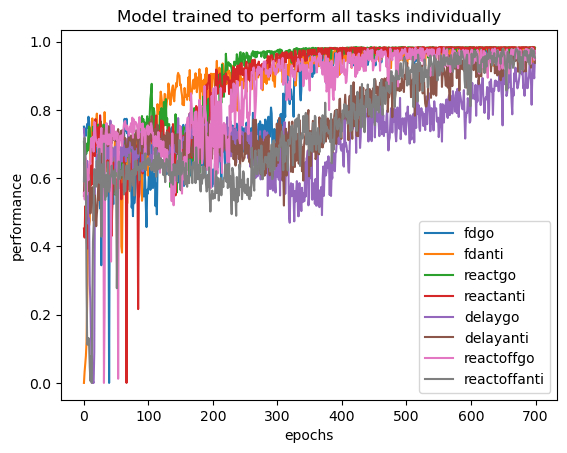

In [7]:
for i,t in enumerate(tsks):
    plt.plot(all_perfs[i], label=t)
plt.legend();

plt.xlabel('epochs');
plt.ylabel('performance');
plt.title('Model trained to perform all tasks individually');

## Load Pickles

#### setting up parameters

In [6]:
### HYPERPARAMETER SETTINGS

training_type = 'interleaved'

opposite_dict = {
    'fdgo': 'fdanti', 
    'fdanti': 'fdgo', 

    'reactgo': 'reactanti',
    'reactanti': 'reactgo',

    'delaygo': 'delayanti',
    'delayanti': 'delaygo', 

    'reactoffgo': 'reactoffanti',
    'reactoffanti': 'reactoffgo',
}

### ---- training paradigm ---- ### 
task_list_unique = ['fdgo','reactgo', 'delaygo', 'reactoffgo', 'reactoffanti'] # 'reactoffgo', 'reactoffanti'] # , 'reactanti_0', 'fdgo_0'] # 
epoch_list = [666, 667, 667, 1000, 1000] 

# task_list_unique = ['fdanti']
# epoch_list = [500]

### ---- hyperparameters ---- ### 
n_tasks = len(task_list_unique)
total_n_epochs = sum(epoch_list) # 4000
paradigm_change_epoch = int(500)
weight_save_int = 100
n_weight_epochs = int(total_n_epochs/weight_save_int)

ctx_size = 64
hpc_size = 64 # c128_h32

lr_ctx = 1e-04
lr_hpc = 1e-03
lr_c2h =  gmean([lr_ctx, lr_hpc])
lr_h2c = gmean([lr_ctx, lr_hpc])

alpha = 0.2
weight_decay = 1e-04

l1norm_ctx = 1e-05
l1norm_hpc = 1e-05
prval_ctx = 0.1
prval_hpc = 0.2


ctx_str = 'c'+str(ctx_size)
hpc_str = 'h'+str(hpc_size)

ctx_lr_str = 'lrctx'+'{:.0e}'.format(lr_ctx)
hpc_lr_str = 'lrhpc'+'{:.0e}'.format(lr_hpc)
c2h_lr_str = 'c2h'+'{:0.1e}'.format(lr_c2h)
h2c_lr_str = 'h2c'+'{:.1e}'.format(lr_h2c)

a_str = 'a'+str(alpha)
wd_str = 'wd'+'{:.0e}'.format(weight_decay)
l1norm_ctx_str = 'l1ctx'+str(l1norm_ctx)
l1norm_hpc_str = 'l1hpc'+str(l1norm_hpc)
prval_ctx_str = 'prctx'+str(prval_ctx)
prval_hpc_str = 'prhpc'+str(prval_hpc)


### ---- other variables ---- ### 
mixed_batch = True
n_epochs_mb = 3000
hpc_loss = 'decorr' # 'recon' # 'decorr' # 'decorr', 'recon', None
hpc_loss_alpha = 1e-3 # '*'

sparse = False
same_lr = False

In [7]:
### CONSTRUCTING STRING FOR MODEL TO LOAD

results_dir = '/home/jason/dev/schema1/results'
figs_dir = '/home/jason/dev/schema1/figs/'
task_paradigm = 'ggg+a/fdgo1000-reactgo1000-delaygo1000-delayanti1000'
 # fdgo750-reactgo750-delaygo750-reactoffgo500-reactoffanti500_ctx64-hpc64


incl_epochs = False
incl_inter_str = True
incl_l1norm = False
incl_prune = False


tasknames = ''
for i in range(n_tasks):
    tasknames += str(task_list_unique[i])
    if incl_epochs: tasknames += str(epoch_list[i])
    if i != (n_tasks-1): tasknames += '-'
tasknames += '_ctx' + str(ctx_size) + '-hpc' + str(hpc_size)
# tasknames = 'fdgo1500-reactgo1500-delayanti1000' # _a0.2_wd1e-05_ctx1e-04_hpc1e-03.pkl'

if incl_inter_str: hp_str = '_'.join((ctx_lr_str, hpc_lr_str, c2h_lr_str, h2c_lr_str)) # a_str, wd_str, 
else: hp_str = '_'.join((ctx_lr_str, hpc_lr_str)) # a_str, wd_str, 
if incl_l1norm: hp_str = '_'.join((hp_str, l1norm_ctx_str,l1norm_hpc_str))
if incl_prune: hp_str = '_'.join((hp_str, prval_ctx_str,prval_hpc_str))

if mixed_batch: tasknames += '_mixedbatch' + str(n_epochs_mb) + 'epochs'
if hpc_loss=='decorr': tasknames += '_decorrloss' + '{:.0e}'.format(hpc_loss_alpha)
elif hpc_loss=='recon': tasknames += '_reconloss' + str(hpc_loss_alpha)
if same_lr: tasknames += '_samelr'

# fname = tasknames + '_' + hp_str
print('results dir: ', results_dir)
print('FILE TYPE TO ACCESS: ', tasknames)
print('hp string: ', hp_str)


results dir:  /home/jason/dev/schema1/results
FILE TYPE TO ACCESS:  fdgo-reactgo-delaygo-reactoffgo-reactoffanti_ctx64-hpc64_mixedbatch3000epochs_decorrloss1e-03
hp string:  lrctx1e-04_lrhpc1e-03_c2h3.2e-04_h2c3.2e-04


#### actual data loading

In [8]:
#### LOAD DATA


load_ckpt = True
load_hp = True; hp=None

load_eval_perfs_and_losses = True
load_train_perfs_and_losses = True
load_trials = True
load_yhats = True

load_hids = False
load_weights = True
load_h2hs = True
load_crosscons = True
load_2outs = False

top_n = 8
ckpt_to_load = -1
load_opposite = None # task_list_unique[-1] # None


opp_list = []
if load_opposite!=None:
    if not isinstance(load_opposite, list):
        opp_list = [opposite_dict[load_opposite]]
    else:
        print("NOT IMPLEMENTED YET FOR LISTS")

    task_list_with_opp = task_list_unique + opp_list
    task_list_opp = [s.replace(load_opposite, opposite_dict[load_opposite]) for s in task_list_unique]

    print('load_opposite of: '+load_opposite+ \
        '\n[this pkl, opposite pkl]')


all_eval_perfs = []
all_eval_losses = []

all_ctx_hids = []
all_hpc_hids = []

all_ctxh2h_weights = []
all_hpch2h_weights = []
all_ctx2hpc_weights = []
all_hpc2ctx_weights = []

general_pth = os.path.join(results_dir, tasknames, '*'+hp_str+'*') # os.path.join(results_dir, '2025*', fname+'*')

if load_eval_perfs_and_losses:
    eval_perf_pkls = glob.glob(os.path.join(general_pth, '**/perfs/eval_perfs.pkl'), recursive=True)
    eval_loss_pkls = glob.glob(os.path.join(general_pth, '**/losses/eval_losses.pkl'), recursive=True)
    sep_loss_pkls = glob.glob(os.path.join(general_pth, '**/losses/losses_sep.pkl'), recursive=True)

    ##### NEED TO CHANGE SO THAT I INCLUDE THE FNAME SINCE THE DATES COULD BE DIFFERENT SO I HAVE TO GLOB AGAIN
    all_eval_perfs, opp_eval_perfs = load_pkls(eval_perf_pkls, top_n=top_n, opposite=[load_opposite,general_pth,'**/perfs/eval_perfs.pkl'], opposite_dict=opposite_dict)
    all_eval_losses, opp_eval_losses = load_pkls(eval_loss_pkls, top_n=top_n, opposite=[load_opposite,general_pth,'**/losses/eval_losses.pkl'], opposite_dict=opposite_dict)
    all_sep_losses, opp_sep_losses = load_pkls(sep_loss_pkls, top_n=top_n, opposite=[load_opposite,general_pth,'**/losses/losses_sep.pkl'], opposite_dict=opposite_dict)
    print('['+str(len(all_eval_perfs))+', '+str(len(opp_eval_perfs))+'] eval perfs and loss pkl loaded')

if load_train_perfs_and_losses:
    train_perf_pkls = glob.glob(os.path.join(general_pth, '**/perfs/train_perfs.pkl'), recursive=True)
    train_loss_pkls = glob.glob(os.path.join(general_pth, '**/losses/train_losses.pkl'), recursive=True)

    all_train_perfs, opp_train_perfs = load_pkls(train_perf_pkls, top_n=top_n, opposite=[load_opposite,general_pth,'**/perfs/train_perfs.pkl'], opposite_dict=opposite_dict)
    all_train_losses, opp_train_losses = load_pkls(train_loss_pkls, top_n=top_n, opposite=[load_opposite,general_pth,'**/losses/train_losses.pkl'], opposite_dict=opposite_dict)
    print('['+str(len(all_train_perfs))+', '+str(len(opp_train_perfs))+'] train perfs and loss pkl loaded')


if load_trials:
    try:
        train_trial_pkls = glob.glob(os.path.join(general_pth, '**/trials/train_trials.pkl'), recursive=True)
        eval_trial_pkls = glob.glob(os.path.join(general_pth, '**/trials/eval_trials.pkl'), recursive=True)

        all_train_trials, opp_train_trials = load_pkls(train_trial_pkls, top_n=top_n, opposite=[load_opposite,general_pth,'**/trials/train_trials.pkl'], opposite_dict=opposite_dict)
        all_eval_trials, opp_eval_trials = load_pkls(eval_trial_pkls, top_n=top_n, opposite=[load_opposite,general_pth,'**/trials/eval_trials.pkl'], opposite_dict=opposite_dict)
        print('['+str(len(all_train_trials))+', '+str(len(all_eval_trials))+'] train and eval trials loaded')
        trials_loaded = True
        
    except: print("FAILED TO LOAD TRIALS"); trials_loaded = False


if load_yhats:
    try:
        train_yhat_pkls = glob.glob(os.path.join(general_pth, '**/yhats/train_yhats.pkl'), recursive=True)
        eval_yhat_pkls = glob.glob(os.path.join(general_pth, '**/yhats/eval_yhats.pkl'), recursive=True)

        all_train_yhats, opp_train_yhats = load_pkls(train_yhat_pkls, top_n=top_n, opposite=[load_opposite,general_pth,'**/yhats/train_yhats.pkl'], opposite_dict=opposite_dict)
        all_eval_yhats, opp_eval_yhats = load_pkls(eval_yhat_pkls, top_n=top_n, opposite=[load_opposite,general_pth,'**/yhats/eval_yhats.pkl'], opposite_dict=opposite_dict)
        print('['+str(len(all_train_yhats))+', '+str(len(all_eval_yhats))+'] train and eval yhats loaded')
        trials_loaded = True
        
    except: print("FAILED TO LOAD YHATS"); trials_loaded = False


if load_hids:
    ctx_hid_pkls = glob.glob(os.path.join(general_pth, '**/hids/*ctx-hids.pkl'), recursive=True)
    hpc_hid_pkls = glob.glob(os.path.join(general_pth, '**/hids/*hpc-hids.pkl'), recursive=True)

    all_ctx_hids, opp_ctx_hids = load_pkls(ctx_hid_pkls, top_n=top_n, opposite=[load_opposite,general_pth,'**/hids/*ctx-hids.pkl'], opposite_dict=opposite_dict)
    all_hpc_hids, opp_hpc_hids = load_pkls(hpc_hid_pkls, top_n=top_n, opposite=[load_opposite,general_pth,'**/hids/*hpc-hids.pkl'], opposite_dict=opposite_dict)
    print('['+str(len(all_ctx_hids))+', '+str(len(opp_ctx_hids))+'] ctx&hpc hids pkl loaded')

if load_weights:
    ctxh2h_pkls = glob.glob(os.path.join(general_pth, '**/weights/*ctx-h2h-weights.pkl'), recursive=True)
    hpch2h_pkls = glob.glob(os.path.join(general_pth, '**/weights/*hpc-h2h-weights.pkl'), recursive=True)
    ctx2hpc_pkls = glob.glob(os.path.join(general_pth, '**/weights/*ctx2hpc-weights.pkl'), recursive=True)
    hpc2ctx_pkls = glob.glob(os.path.join(general_pth, '**/weights/*hpc2ctx-weights.pkl'), recursive=True)

    all_ctxh2h_weights, opp_ctxh2h_weights = load_pkls(ctxh2h_pkls, top_n=top_n, opposite=[load_opposite,general_pth,'**/weights/*ctx-h2h-weights.pkl'], opposite_dict=opposite_dict)
    all_hpch2h_weights, opp_hpch2h_weights = load_pkls(hpch2h_pkls, top_n=top_n, opposite=[load_opposite,general_pth,'**/weights/*hpc-h2h-weights.pkl'], opposite_dict=opposite_dict)
    all_ctx2hpc_weights, opp_ctx2hpc_weights = load_pkls(ctx2hpc_pkls, top_n=top_n, opposite=[load_opposite,general_pth,'**/weights/*ctx2hpc-weights.pkl'], opposite_dict=opposite_dict)
    all_hpc2ctx_weights, opp_hpc2ctx_weights = load_pkls(hpc2ctx_pkls, top_n=top_n, opposite=[load_opposite,general_pth,'**/weights/*hpc2ctx-weights.pkl'], opposite_dict=opposite_dict)
    print('['+str(len(all_ctxh2h_weights))+', '+str(len(opp_ctxh2h_weights))+'] weights pkl loaded')

if load_2outs:
    ctx2out_pkls = glob.glob(os.path.join(general_pth, '**/weights/*ctx2out-weights.pkl'), recursive=True)
    hpc2out_pkls = glob.glob(os.path.join(general_pth, '**/weights/*hpc2out-weights.pkl'), recursive=True)
    all_ctx2out_weights, opp_ctx2out_weights = load_pkls(ctx2out_pkls, top_n=top_n, opposite=[load_opposite,general_pth,'**/weights/*ctx2out-weights.pkl'], opposite_dict=opposite_dict)
    all_hpc2out_weights, opp_hpc2out_weights = load_pkls(hpc2out_pkls, top_n=top_n, opposite=[load_opposite,general_pth,'**/weights/*hpc2out-weights.pkl'], opposite_dict=opposite_dict)
    print('hid2outs loaded')

if load_hp:
    hp = load_hparams(glob.glob(os.path.join(general_pth, '**/*.pth'), recursive=True)[ckpt_to_load].rsplit('/',1)[0])
    hp_clean = copy.deepcopy(hp)
    
if load_ckpt:
    ckpt_paths = glob.glob(os.path.join(general_pth, '**/*.pth'), recursive=True)[ckpt_to_load]
    model, opp_model, hp = load_checkpoint(ckpt_paths, hp=hp, opposite=[load_opposite,general_pth,'**/*.pth'], opposite_dict=opposite_dict)


if len(opp_eval_perfs)>0: opps_loaded = True # in case we want to load opposites but there are none
else: opps_loaded = False ########### THIS WILL BREAK

if len(all_eval_perfs)<top_n: top_n = len(all_eval_perfs)
# fdgo1500-reactgo1500-delayanti1000_a0.2_wd1e-05_ctx1e-04_hpc1e-03_ctx-h2h-weights.pkl



[1, 0] eval perfs and loss pkl loaded
[1, 0] train perfs and loss pkl loaded
[1, 1] train and eval trials loaded
[1, 1] train and eval yhats loaded
[1, 0] weights pkl loaded
loaded model from:  /home/jason/dev/schema1/results/fdgo-reactgo-delaygo-reactoffgo-reactoffanti_ctx64-hpc64_mixedbatch3000epochs_decorrloss1e-03/2025-07-01_lrctx1e-04_lrhpc1e-03_c2h3.2e-04_h2c3.2e-04/fdgo-reactgo-delaygo-reactoffgo-reactoffanti_ctx64-hpc64_mixedbatch3000epochs_decorrloss1e-03.pth
NO OPPS MODEL FOUND TO LOAD


#### sanity check plots (FIGS IN PAPER)

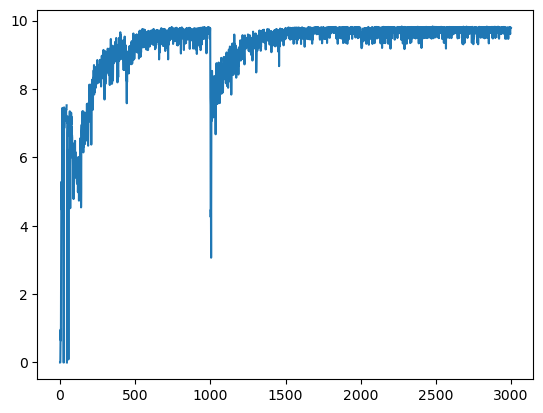

In [19]:
plt.plot(all_train_perfs[-1])

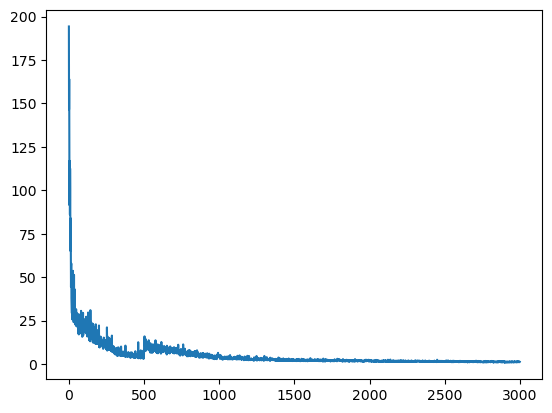

In [12]:
plt.plot(all_train_losses[-1][:])

In [9]:
print(eval_perf_pkls)
print(train_perf_pkls)

['/home/jason/dev/schema1/results/fdgo-reactgo-delaygo-reactoffanti_ctx64-hpc64_mixedbatch3000epochs/2025-06-20_lrctx1e-04_lrhpc1e-03_c2h3.2e-04_h2c3.2e-04/perfs/eval_perfs.pkl']
['/home/jason/dev/schema1/results/fdgo-reactgo-delaygo-reactoffanti_ctx64-hpc64_mixedbatch3000epochs/2025-06-20_lrctx1e-04_lrhpc1e-03_c2h3.2e-04_h2c3.2e-04/perfs/train_perfs.pkl']


(3000, 5, 1)
(3000, 5, 1)


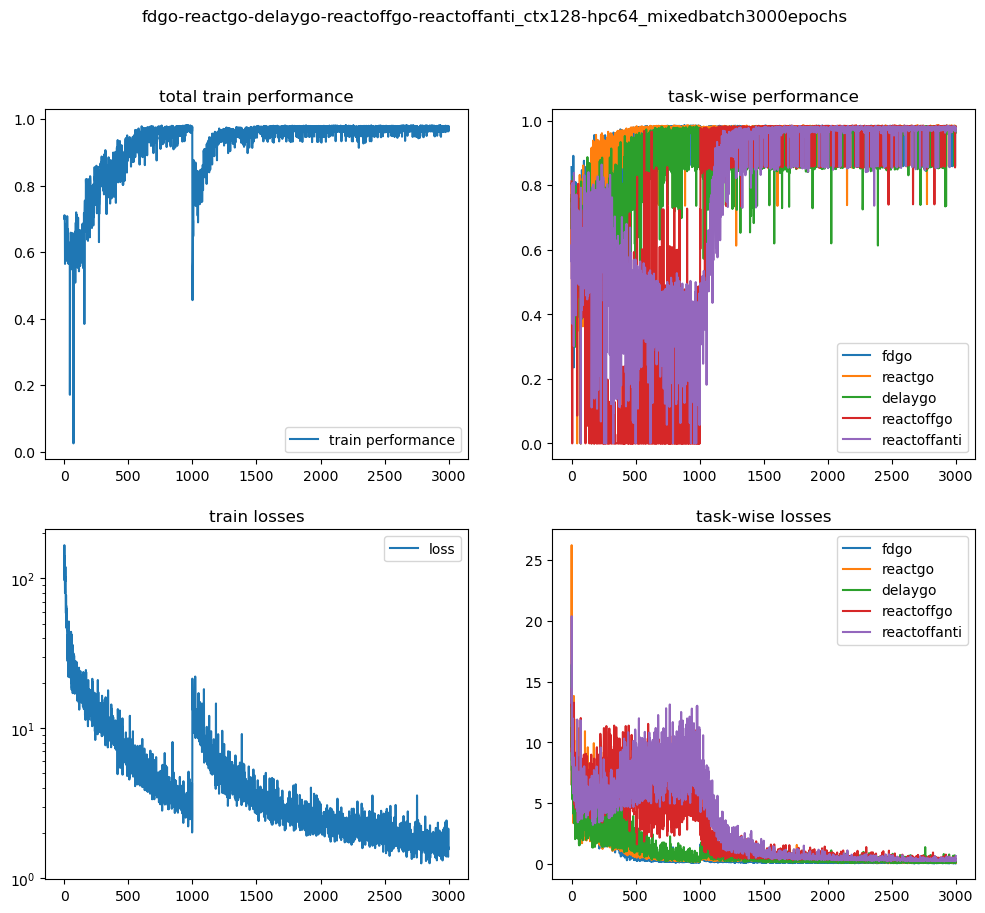

In [18]:
fig, axs = plt.subplots(2, 2, figsize=(12,10)) # , gridspec_kw={'height_ratios':[0.1,0.4,0.1,0.4]})


tmp_eval_perfs = np.asarray(all_eval_perfs[-1])
tmp_train_perfs = np.asarray(all_train_perfs[-1])
tmp_losses = np.asarray(all_eval_losses[-1])

print(tmp_eval_perfs.shape)
print(tmp_losses.shape)


#### [0][0] PLOT
axs[0,0].plot(tmp_train_perfs / 10, label='train performance')


#### [1][0] PLOT
try:
    axs[1][0].plot(np.asarray(all_train_losses[-1][:]) - hpc_loss_alpha*np.asarray(all_sep_losses[-1][:]), label='standard loss')
    axs[1][0].plot(all_sep_losses[-1][:], label='hpc loss')
    # axs[1][0].set_yscale('log')
except: 
    axs[1][0].plot(all_train_losses[-1][:], label='loss')
axs[1][0].set_yscale('log')


#### [0][1] PLOT
for i in range(tmp_eval_perfs.shape[1]):
    axs[0][1].plot(tmp_eval_perfs[:,i,0]/10, label=task_list_unique[i]) # print(len(tmp_eval_perfs[:,i,0]))


#### [1][1] PLOT
for i in range(tmp_losses.shape[1]):
    axs[1][1].plot(tmp_losses[:,i,0]/10, label=task_list_unique[i])




# #### [1][1] PLOT
# if trials_loaded:
#     print()
#     # all_train_trials all_train_yhats

fig.suptitle(tasknames)
axs[0,0].set_title('total train performance')
axs[0,1].set_title('task-wise performance')
axs[1,0].set_title('train losses')
axs[1,1].set_title('task-wise losses')
axs[0][0].legend(); axs[1][0].legend(); axs[0][1].legend(); axs[1][1].legend();

# plt.yscale('log')

Text(0.5, 0.98, 'fdgo-reactgo-delaygo-reactoffgo-reactoffanti_ctx128-hpc64_mixedbatch3000epochs_decorrloss1e-03')

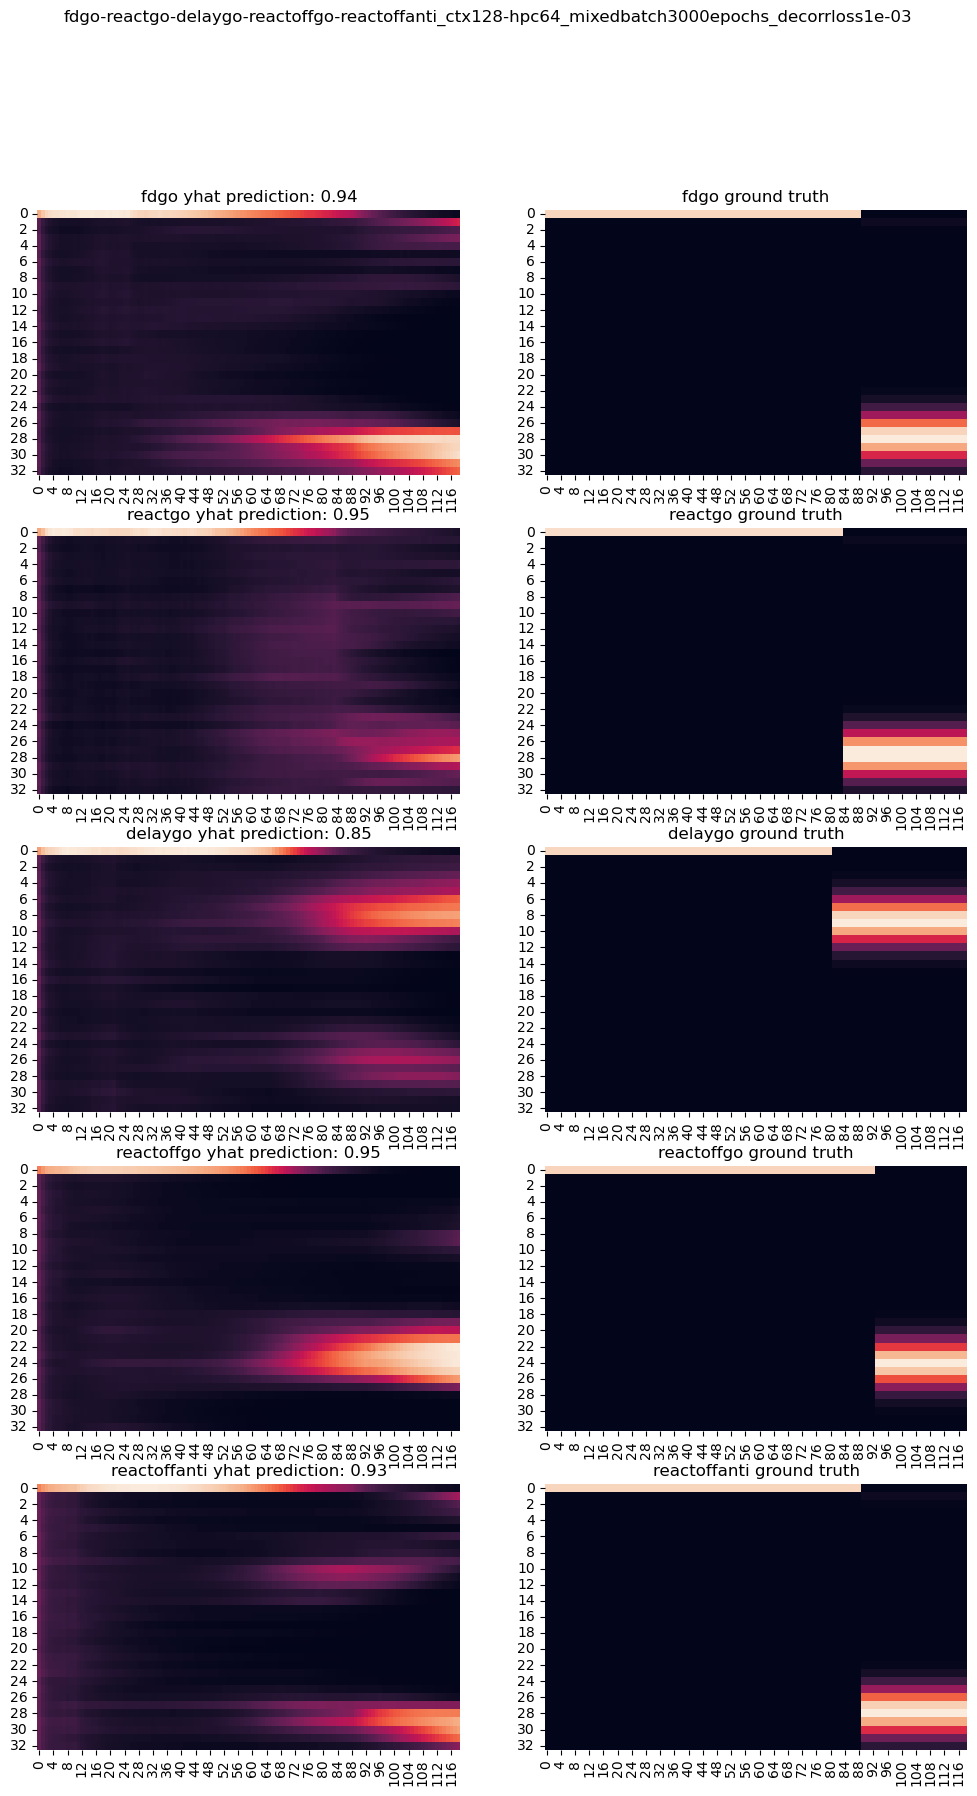

In [61]:
# task_list_unique

batch_n = 0

fig, axs = plt.subplots(n_tasks, 2, figsize=(12,20)) # , gridspec_kw={'height_ratios':[0.1,0.4,0.1,0.4]})

this_yhat_set = all_eval_yhats[-1][-1] # shape = (5, 1, 108, 8, 33) || last pickle, last epoch
this_trial_set = all_eval_trials[-1][-1] # shape = (5, 1)
this_perf_set = np.asarray(all_eval_perfs[0][-1]) / 10


yhat_hms = []
trial_hms = []

for i,lbl in enumerate(task_list_unique):
    yhat_hm = sns.heatmap(np.asarray(this_yhat_set[i][0])[:,batch_n,:].T, cbar=False, ax=axs[i][0]);
    yhat_hms.append(yhat_hm)
    axs[i,0].set_title(lbl + ' yhat prediction: ' + str(this_perf_set[i][0])[:4])


    trial_gt = this_trial_set[i][0].y
    trial_hm = sns.heatmap(np.asarray(trial_gt)[:,batch_n,:].T, cbar=False, ax=axs[i][1]);
    trial_hms.append(trial_hm)
    axs[i,1].set_title(lbl + ' ground truth')

fig.suptitle(tasknames)
# fig.tight_layout()



In [ ]:
print('task_list_unique:   ', task_list_unique)
if opps_loaded:
    print('task_list_with_opp: ', task_list_with_opp)
    print('task_list_opp:      ', task_list_opp)

task_list_unique:    ['fdgo', 'reactgo', 'delaygo', 'reactoffgo', 'reactoffanti']


## Run inference

#### misc helper funcs

In [9]:
def get_saccade_onset(y_loc):
    # y_loc shape = (n timesteps, n batches)
    timeline = y_loc[:,0]
    return [j for j,val in enumerate(timeline) if val>0][0]

 # , time_bounds=[90,100]):
# while trial.x.shape[0]<time_bounds[0] or trial.x.shape[0]>time_bounds[1]: 
def run_model_inference(model, task, hp, inf_trial=None, lesion=None, return_y=False):
    from model import get_perf

    if inf_trial!=None: trial = inf_trial
    else: trial = generate_trials(task, hp, hp['mode'], batch_size=hp['batch_size'])

    inputs = torch.tensor(trial.x, dtype=torch.float32) # .to(device)
    mask = torch.tensor(trial.c_mask, dtype=torch.float32) # .to(device)
    y = torch.tensor(trial.y, dtype=torch.float32) # .to(device)
    # y_loc = torch.tensor(trial.y_loc, dtype=torch.float32)

    # prev_state = torch.zeros(hp['batch_size'], hp['out_size']).to(device)
    ctx_hid = torch.zeros(hp['batch_size'], hp['hid_size_ctx']) # .to(device)
    hpc_hid = torch.zeros(hp['batch_size'], hp['hid_size_hpc']) # .to(device)
    ctx_hids = []; hpc_hids = []

    ### ----- if lesion = true ----- ### 
    if lesion != None:
        idxs, region, layer, lesion_type = lesion

        if lesion_type=='mask':
            if region=='ctx':
                if layer=='h2h': lesion_out_mask = torch.ones(model.h2h_ctx.out_features)
                elif layer=='output': lesion_out_mask = torch.ones(model.ctx2out.out_features)
            elif region=='hpc': 
                if layer=='h2h': lesion_out_mask = torch.ones(model.h2h_hpc.out_features)
                elif layer=='output': lesion_out_mask = torch.ones(model.hpc2out.out_features)

            for neuron_idx in idxs: lesion_out_mask[neuron_idx] = 0.0
            # print(lesion_out_mask.sum())
        # print(lesion_type)


    ### ----- run inference trial ----- ### 
    losses = []; yhats = []
    loss = 0
    n_timesteps = inputs.shape[0]
    for t in range(n_timesteps):

        ### ----- if lesion using hooks ----- ### 
        if lesion!=None and lesion_type=='hook':
            def lesion_hook(module, input, output):
                for neuron_idx in idxs:
                    output[:, neuron_idx] = 0.0
                return output
            
            handles = []
            if region=='ctx':
                if layer=='h2h':
                    handles.append(model.h2h_ctx.register_forward_hook(lesion_hook))
                    handles.append(model.ctx2hpc.register_forward_hook(lesion_hook))
                elif layer=='output':
                    handles.append(model.ctx2out.register_forward_hook(lesion_hook))

            elif region=='hpc':  
                if layer=='h2h':
                    handles.append(model.h2h_hpc.register_forward_hook(lesion_hook))
                    handles.append(model.hpc2ctx.register_forward_hook(lesion_hook))
                elif layer=='output':
                    handles.append(model.hpc2out.register_forward_hook(lesion_hook))

            else: print("invalid region for lesion")
        
        ### ----- if lesion using mask ----- ### 
        if lesion!=None and lesion_type=='mask':
            y_hat, ctx_hid, hpc_hid = model(inputs[t], ctx_hid , hpc_hid, (region, layer, lesion_out_mask))
        ### ----- run normal inference ----- ### 
        else:
            y_hat, ctx_hid, hpc_hid = model(inputs[t], ctx_hid , hpc_hid) # .to(device)


        l = model.compute_loss(y[t], y_hat, mask[t*hp['batch_size']:(t+1)*hp['batch_size']])

        # performance.append(perf)
        loss += l
        losses.append(loss)
        yhats.append(y_hat.cpu().detach().numpy())

        ctx_hids.append(ctx_hid.detach().cpu())
        hpc_hids.append(hpc_hid.detach().cpu())

        if lesion and lesion_type=='hook': 
            for handle in handles: handle.remove()


    perf = np.mean(get_perf(np.asarray(yhats), trial.y_loc)) / 10 # .cpu().detach().numpy()

    hids = (ctx_hids, hpc_hids)
    if return_y: metrics = (perf, losses, yhats)
    else: metrics = (perf,losses)

    if hp['mode'] == 'inference': # hp['probe'] or hp['no_stim']:
        return metrics, hids, trial, -1
    else:
        return metrics, hids, trial, get_saccade_onset(trial.y_loc)
    #   (ctx_h2h_weights, hpc_h2h_weights, ctx2hpc_weights, hpc2ctx_weights), 

#### test run

In [10]:
# task = 'fdgo'
inf_all_eval_perfs = [] # unused
inf_all_eval_losses = [] # unused
ctx_all_hids = [] # shape = n_tasks x n_reps x n_timesteps x batch size x n_neuron | e.g. (4, 1, 20, 64, 64)
hpc_all_hids = [] # same as above
y_all_reacts = [] # shape = n_tasks; the timestamp for the saccade for each task
inf_all_task_lens = []# shape = n_tasks; the timelength of each task

inf_all_opp_eval_perfs = []
inf_all_opp_eval_losses = []
ctx_all_opp_hids = []
hpc_all_opp_hids = []
y_all_opp_reacts = []
inf_all_opp_task_lens = []

y_reacts = []; y_opp_reacts = []

all_trials = []
all_opp_trials = []
time_bounds = [100,100]

# target_locs = [0, (120/360)*(2*np.pi), (240/360)*(2*np.pi)]
n_reps = 1

# rng = np.random.RandomState(1) # hp['rng']
hp['batch_size'] = 64
batch_size= hp['batch_size']

hp['mode'] = 'inference'
hp['y_loc'] = np.random.rand(batch_size)*2*np.pi # fixing the target location
hp['no_stim'] = 0 # have a stimulus bump or not
hp['probe'] = 'probe' # probe the network or not
hp['tdim'] = 40 # if want to fix the tdim; comment out if not
hp['fxtn_val'] = 0.5 # fxtn val = -1 means work as normal, 0,1=0,1 respectively; 0.5 = 1 then 0


### ----- run inference for each trial ----- ### 
for i,task in enumerate(task_list_unique):

    (perf, losses), hids, trial, y_react = run_model_inference(model, task, hp) # , time_bounds)

    inf_all_eval_perfs.append(perf); inf_all_eval_losses.append(losses)
    ctx_all_hids.append(hids[0]); hpc_all_hids.append(hids[1])
    y_reacts.append(y_react); all_trials.append(trial)
    inf_all_task_lens.append(np.asarray(hids[0]).shape[0])
    print('task: ', task, ' | size: ', np.asarray(hids[0]).shape)

    ## add the non-opposite tasks to the opp one for easier comparison
    if opps_loaded:
        if task==load_opposite: #  and task!='reactoffgo':
            (perf, losses), hids, trial, y_react = run_model_inference(model, opposite_dict[load_opposite], hp) # , time_bounds)

        inf_all_opp_eval_perfs.append(perf); inf_all_opp_eval_losses.append(losses)
        ctx_all_opp_hids.append(hids[0]); hpc_all_opp_hids.append(hids[1])
        y_opp_reacts.append(y_react); all_opp_trials.append(trial)
        inf_all_opp_task_lens.append(np.asarray(hids[0]).shape[0])
        print('opp task: ', task, ' | size: ', np.asarray(hids[0]).shape)


inf_all_ctx_hids = np.swapaxes(np.asarray(ctx_all_hids), 1, 2)
inf_all_hpc_hids = np.swapaxes(np.asarray(hpc_all_hids), 1, 2)
print('\nhid shape: ', inf_all_ctx_hids.shape)

if opps_loaded:
    inf_all_opp_ctx_hids = np.swapaxes(np.asarray(ctx_all_opp_hids), 1, 2)
    inf_all_opp_hpc_hids = np.swapaxes(np.asarray(hpc_all_opp_hids), 1, 2)
else: print('no opposite hids')

# np.asarray(ctx_h2h_weights).shape
# ctx_h2h_weights, hpc_h2h_weights, ctx2hpc_weights, hpc2ctx_weights = all_weights

task:  fdgo  | size:  (40, 64, 64)
task:  reactgo  | size:  (40, 64, 64)
task:  delaygo  | size:  (40, 64, 64)
task:  reactoffgo  | size:  (40, 64, 64)
task:  reactoffanti  | size:  (40, 64, 64)

hid shape:  (5, 64, 40, 64)
no opposite hids


### trial fixed y sanity check

In [11]:
# if not hp['probe']:    
#     print("trial fixation locations")
#     for i,trial in enumerate(all_opp_trials): # see what the fix locs are
#         timeline = trial.y_loc[:,0]
#         print(task_list_opp[i] + ': ' + str([val for j,val in enumerate(timeline) if val>0][0]))

#     print("\nreaction onsets, out of {} total timesteps".format(inf_all_ctx_hids[0].shape[0]))
#     for i,t in enumerate(y_opp_reacts): # see what the fix locs are
#         # timeline = trial.y_loc[:,0]
#         print(task_list_opp[i] + ': ' + str(t))

#     print()
#     n_combs = math.comb(len(all_trials), 2) # (n_tasks*(n_tasks-1)) / 2
#     for i in range(n_combs):
#         for j in range(n_combs-(i+1)):
#             comp = task_list_unique[i] + ' x ' + task_list_unique[j] + ' target y diff: '
#             print(comp + str((all_trials[i].y - all_trials[j].y).flatten().sum()))

In [12]:
# # trials[0].x.shape # = (100, 64, 85)
# # trials[0].x[-1][0][1:-20]

# tmp_trial = trial # trials[2]
# tmp_x = tmp_trial.x[:,0,:]
# tmp_y = tmp_trial.y[:,0,:]

# fig, axs = plt.subplots(4, 1, figsize=(5,7), gridspec_kw={'height_ratios':[0.1,0.4,0.1,0.4]})
# fig.suptitle(f'tasks:') # , fontsize=16)

# # stim_cue_df = pd.DataFrame({'x_stim': x[:,0], 'y_stim': y[:,0]})

# sns.lineplot(x=np.arange(0,len(tmp_x[:,0]),1), y=tmp_x[:,0], ax=axs[0])

# # yticks = np.linspace(0, len(x.T)[1:-20,:]-1, 10)
# # axs[1].yticks(range(4), range(4))

# sns.heatmap(tmp_x.T[1:-20,:], yticklabels=True, cbar=False, ax=axs[1], ) # xticklabels=np.arange(0,len(x[:,0]),5)
# axs[1].set_yticks(np.arange(0,64,16)) # positions
# axs[1].set_yticklabels(np.arange(0,64,16)) # labels

# # yticklabels = [np.arange(0,len(x.T),1) for i in yticks]

# sns.lineplot(x=np.arange(0,len(tmp_y[:,0]),1), y=tmp_y[:,0], ax=axs[2])
# sns.heatmap(tmp_y.T[1:,:], yticklabels=True, cbar=False, ax=axs[3], )
# axs[3].set_yticks(np.arange(0,32,8)) # positions
# axs[3].set_yticklabels(np.arange(0,32,8))

# # axs.set_xticks()
# plt.show()


## Weight evolution analyses (only used for one plot)

### process weights

In [10]:
# to_plot = 'all_ctx_h2h_flattened'
run_num = 0
# total_n_epochs = 4000
# weight_save_int = 100
# paradigm_change_epoch = 1000

# n_weight_epochs = int(total_n_epochs/weight_save_int)
vline_loc = int(paradigm_change_epoch/weight_save_int)
sort_col = vline_loc-1

all_ctx_h2h_flattened = [np.array([np.asarray(x).flatten() for x in all_ctxh2h_weights[i]]).T for i in range(top_n)]
all_hpc_h2h_flattened = [np.array([np.asarray(x).flatten() for x in all_hpch2h_weights[i]]).T for i in range(top_n)]
all_ctx2hpc_flattened = [np.array([np.asarray(x).flatten() for x in all_ctx2hpc_weights[i]]).T for i in range(top_n)]
all_hpc2ctx_flattened = [np.array([np.asarray(x).flatten() for x in all_hpc2ctx_weights[i]]).T for i in range(top_n)]

all_ctx_h2h_flattened = [np.array(sorted(all_ctx_h2h_flattened[i], key=lambda x: x[sort_col], reverse=False)) for i in range(top_n)]
all_hpc_h2h_flattened = [np.array(sorted(all_hpc_h2h_flattened[i], key=lambda x: x[sort_col], reverse=False)) for i in range(top_n)]
all_ctx2hpc_flattened = [np.array(sorted(all_ctx2hpc_flattened[i], key=lambda x: x[sort_col], reverse=False)) for i in range(top_n)]
all_hpc2ctx_flattened = [np.array(sorted(all_hpc2ctx_flattened[i], key=lambda x: x[sort_col], reverse=False)) for i in range(top_n)]

print(str(len(all_ctx_h2h_flattened)) + ' weight data files processed successfully')

plt_name_dict = {
    'all_ctx_h2h_flattened': all_ctx_h2h_flattened,
    'all_hpc_h2h_flattened': all_hpc_h2h_flattened,
    'all_ctx2hpc_flattened': all_ctx2hpc_flattened,
    'all_hpc2ctx_flattened': all_hpc2ctx_flattened,
}

if opps_loaded:
    opp_ctx_h2h_flattened = [np.array([np.asarray(x).flatten() for x in opp_ctxh2h_weights[i]]).T for i in range(top_n)]
    opp_hpc_h2h_flattened = [np.array([np.asarray(x).flatten() for x in opp_hpch2h_weights[i]]).T for i in range(top_n)]
    opp_ctx2hpc_flattened = [np.array([np.asarray(x).flatten() for x in opp_ctx2hpc_weights[i]]).T for i in range(top_n)]
    opp_hpc2ctx_flattened = [np.array([np.asarray(x).flatten() for x in opp_hpc2ctx_weights[i]]).T for i in range(top_n)]

    opp_ctx_h2h_flattened = [np.array(sorted(opp_ctx_h2h_flattened[i], key=lambda x: x[sort_col], reverse=False)) for i in range(top_n)]
    opp_hpc_h2h_flattened = [np.array(sorted(opp_hpc_h2h_flattened[i], key=lambda x: x[sort_col], reverse=False)) for i in range(top_n)]
    opp_ctx2hpc_flattened = [np.array(sorted(opp_ctx2hpc_flattened[i], key=lambda x: x[sort_col], reverse=False)) for i in range(top_n)]
    opp_hpc2ctx_flattened = [np.array(sorted(opp_hpc2ctx_flattened[i], key=lambda x: x[sort_col], reverse=False)) for i in range(top_n)]
    
    print(str(len(opp_ctx_h2h_flattened)) + ' OPPOSITE weight data files processed successfully')

# print('['+str(len(all_ctx_h2h_flattened))+', '+str(len(opp_ctx_h2h_flattened))+'] weight data processed successfully')

1 weight data files processed successfully
1 OPPOSITE weight data files processed successfully


### heatmaps

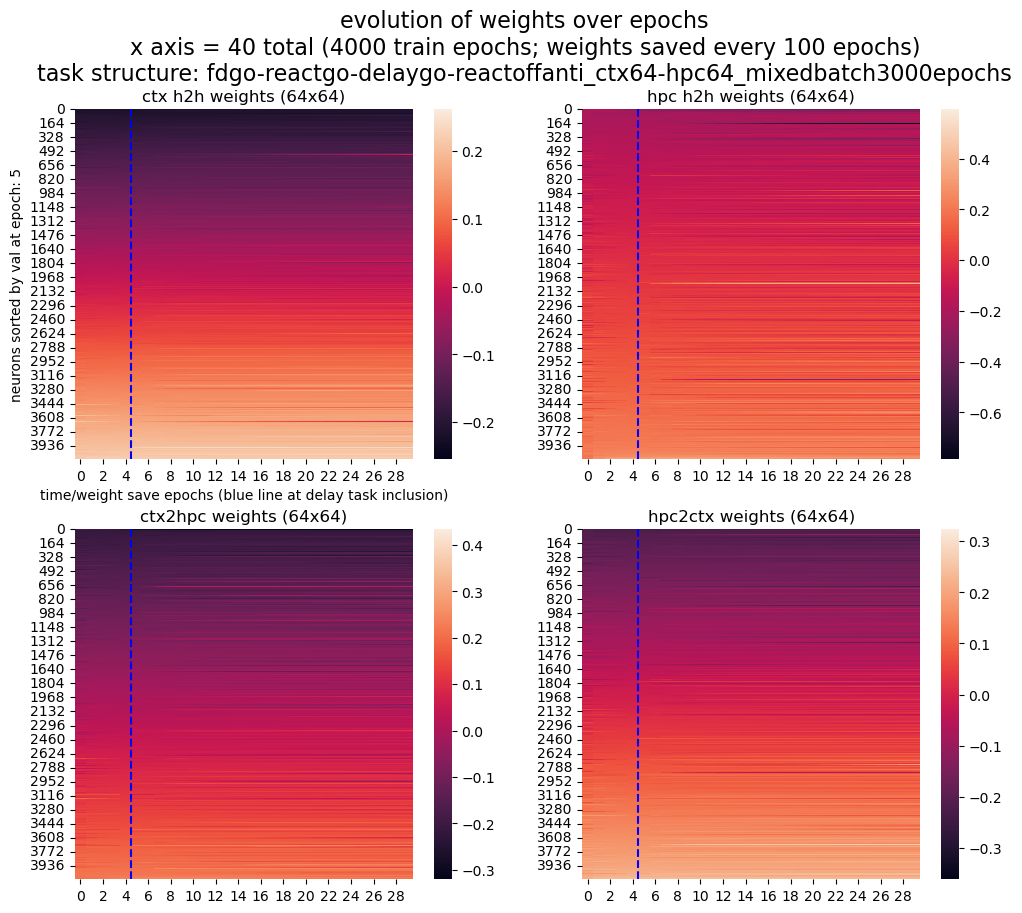

In [14]:
save_fig = False
run_num = 0

fig, axs = plt.subplots(2,2, figsize=(12,10))
# f,(ax1,ax2,ax3,ax4) = plt.subplots(2,2)

g1 = sns.heatmap(all_ctx_h2h_flattened[run_num], ax=axs[0][0])
g2 = sns.heatmap(all_hpc_h2h_flattened[run_num], ax=axs[0][1])
g3 = sns.heatmap(all_ctx2hpc_flattened[run_num], ax=axs[1][0])
g4 = sns.heatmap(all_hpc2ctx_flattened[run_num], ax=axs[1][1])


fig.suptitle('evolution of weights over epochs\n' \
             'x axis = '+str(n_weight_epochs)+' total ('+str(total_n_epochs)+ \
             ' train epochs; weights saved every '+str(weight_save_int)+' epochs)\n' \
            'task structure: '+tasknames, fontsize=16)
# fig.suptitle(label='task structure: '+tasknames[:-1])

axs[0,0].set_title('ctx h2h weights ('+str(ctx_size)+'x'+str(hpc_size)+')')
axs[0,1].set_title('hpc h2h weights ('+str(ctx_size)+'x'+str(hpc_size)+')')
axs[1,0].set_title('ctx2hpc weights ('+str(ctx_size)+'x'+str(hpc_size)+')')
axs[1,1].set_title('hpc2ctx weights ('+str(ctx_size)+'x'+str(hpc_size)+')')

axs[0,0].axvline(x =vline_loc, ls='--', color = 'b' , label = 'axvline - full height')
axs[0,1].axvline(x =vline_loc, ls='--', color = 'b' , label = 'axvline - full height')
axs[1,0].axvline(x =vline_loc, ls='--', color = 'b' , label = 'axvline - full height')
axs[1,1].axvline(x =vline_loc, ls='--', color = 'b' , label = 'axvline - full height')


axs[0,0].set_xlabel('time/weight save epochs ' \
                    '(blue line at delay task inclusion)') #, fontsize=6)
axs[0,0].set_ylabel('neurons sorted by val at epoch: '+str(sort_col+1))

plt.show()

if save_fig:
    
    print('heatmap saved')

### dist from init weights (FIG IN PAPER)

In [11]:
# gets the distance of each column from the init; sum of distance normalized by num units
def get_heatmap_diff_list(df_list, top_n, start_idx=0, get_avg=False): 
    results = []

    for i in range(top_n):
        df = df_list[i].T
        df = df[start_idx:]
        norm = len(df[0])

        diffs = []
        for i in range(len(df)-1):
            diff = np.sum(np.abs(df[i+1]-df[0]))
            diffs.append(diff/norm)
        results.append(diffs)
    
    if get_avg: return np.mean(np.asarray(results), axis=0)
    
    return results

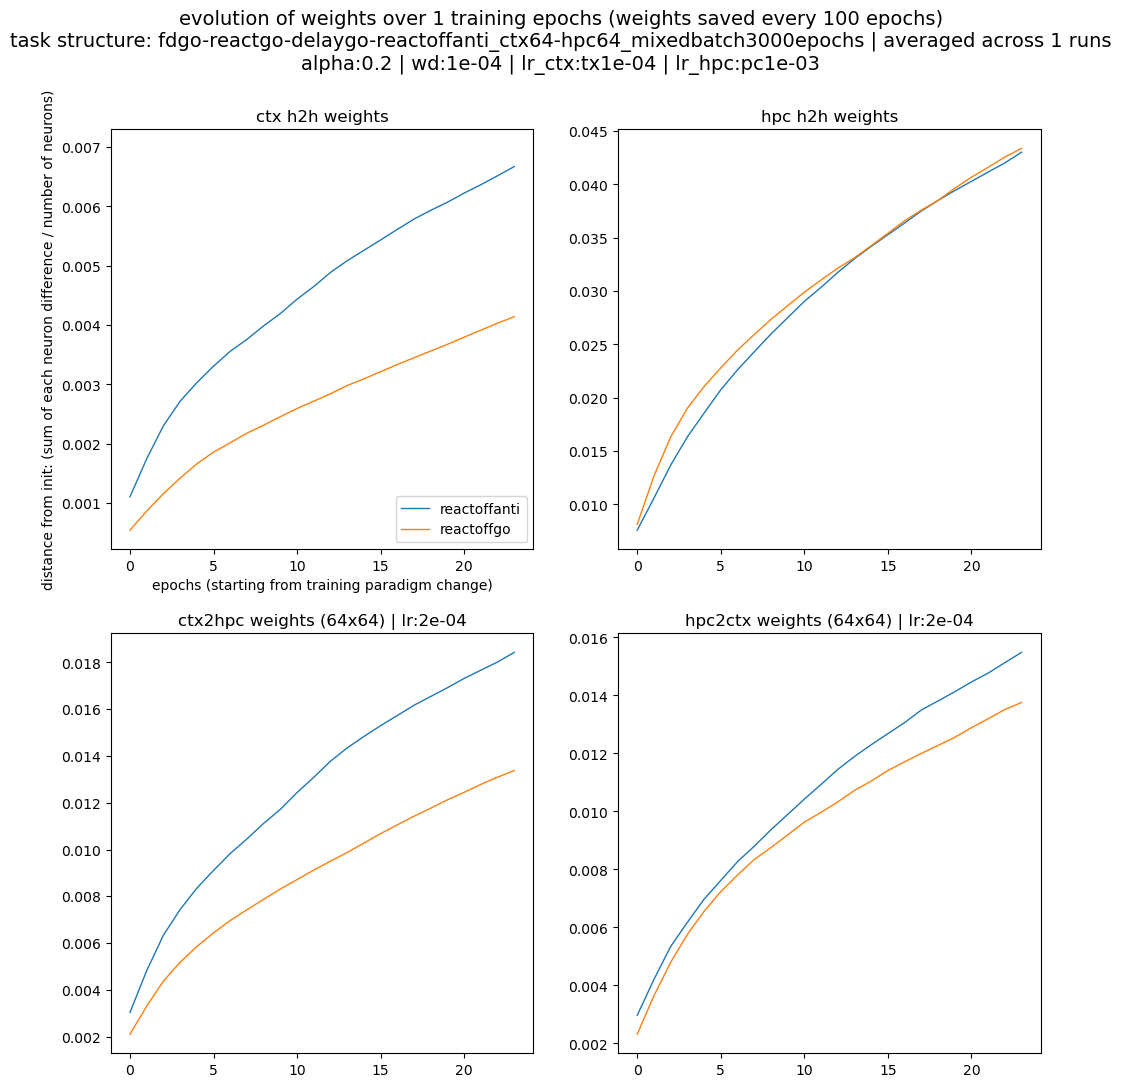

In [14]:
save_fig = False
plot_opp_weights = True
plot_avg = True
weight_plot_start =  vline_loc

zero_plots = False

ctx_h2h_diffs = get_heatmap_diff_list(all_ctx_h2h_flattened, top_n, weight_plot_start, plot_avg)
hpc_h2h_diffs = get_heatmap_diff_list(all_hpc_h2h_flattened, top_n, weight_plot_start, plot_avg)
ctx2hpc_diffs = get_heatmap_diff_list(all_ctx2hpc_flattened, top_n, weight_plot_start, plot_avg)
hpc2ctx_diffs = get_heatmap_diff_list(all_hpc2ctx_flattened, top_n, weight_plot_start, plot_avg)

if zero_plots:
    ctx_h2h_diffs = ctx_h2h_diffs - ctx_h2h_diffs[vline_loc]
    hpc_h2h_diffs = hpc_h2h_diffs - hpc_h2h_diffs[vline_loc]
    ctx2hpc_diffs = ctx2hpc_diffs - ctx2hpc_diffs[vline_loc]
    hpc2ctx_diffs = hpc2ctx_diffs - hpc2ctx_diffs[vline_loc]

if opps_loaded: 
    opp_ctx_h2h_diffs = get_heatmap_diff_list(opp_ctx_h2h_flattened, top_n, weight_plot_start, plot_avg)
    opp_hpc_h2h_diffs = get_heatmap_diff_list(opp_hpc_h2h_flattened, top_n, weight_plot_start, plot_avg)
    opp_ctx2hpc_diffs = get_heatmap_diff_list(opp_ctx2hpc_flattened, top_n, weight_plot_start, plot_avg)
    opp_hpc2ctx_diffs = get_heatmap_diff_list(opp_hpc2ctx_flattened, top_n, weight_plot_start, plot_avg)

    if zero_plots:
        opp_ctx_h2h_diffs = opp_ctx_h2h_diffs - opp_ctx_h2h_diffs[vline_loc]
        opp_hpc_h2h_diffs = opp_hpc_h2h_diffs - opp_hpc_h2h_diffs[vline_loc]
        opp_ctx2hpc_diffs = opp_ctx2hpc_diffs - opp_ctx2hpc_diffs[vline_loc]
        opp_hpc2ctx_diffs = opp_hpc2ctx_diffs - opp_hpc2ctx_diffs[vline_loc]

# xvals = len(ctx_h2h_diffs)
n_points = len(ctx_h2h_diffs)

fig, axs = plt.subplots(2, 2, figsize=(12,12)) # , aspect='equal')

axs[0][0].plot(ctx_h2h_diffs, linewidth=1, label=load_opposite)
axs[0][1].plot(hpc_h2h_diffs, linewidth=1, label=load_opposite)
axs[1][0].plot(ctx2hpc_diffs, linewidth=1, label=load_opposite)
axs[1][1].plot(hpc2ctx_diffs, linewidth=1, label=load_opposite)

if plot_opp_weights:
    axs[0][0].plot(opp_ctx_h2h_diffs, linewidth=1, label=opp_list)
    axs[0][1].plot(opp_hpc_h2h_diffs, linewidth=1, label=opp_list)
    axs[1][0].plot(opp_ctx2hpc_diffs, linewidth=1, label=opp_list)
    axs[1][1].plot(opp_hpc2ctx_diffs, linewidth=1, label=opp_list)



# ### Graph Cosmetics ###
# # vline_loc 
# axs[0,0].axvline(x = vline_loc, ls='--', color = 'r' , label = 'train paradigm change')
# axs[0,1].axvline(x = vline_loc, ls='--', color = 'r' , label = 'train paradigm change')
# axs[1,0].axvline(x = vline_loc, ls='--', color = 'r' , label = 'train paradigm change')
# axs[1,1].axvline(x = vline_loc, ls='--', color = 'r' , label = 'train paradigm change')

ax0_ymax = axs[0,0].get_ylim()[1]
axs[0,0].plot(ax0_ymax)

'''
axs[0,0].axline((0, axs[0,0].get_ylim()[0]), (n_points, axs[0,0].get_ylim()[1]), \
                ls='--', dashes=(5, 10), color='black', linewidth=1)
axs[0,1].axline((0, axs[0,1].get_ylim()[0]), (n_points, axs[0,1].get_ylim()[1]), \
                ls='--', dashes=(5, 10), color='black', linewidth=1)
axs[1,0].axline((0, axs[1,0].get_ylim()[0]), (n_points, axs[1,0].get_ylim()[1]), \
                ls='--', dashes=(5, 10), color='black', linewidth=1)
axs[1,1].axline((0, axs[1,1].get_ylim()[0]), (n_points, axs[1,1].get_ylim()[1]), \
                ls='--', dashes=(5, 10), color='black', linewidth=1)
'''

fig.suptitle('evolution of weights over '+str(len(all_ctx_h2h_flattened))+\
             ' training epochs (weights saved every '+str(weight_save_int)+' epochs)\n' \
            'task structure: '+tasknames+' | averaged across '+str(top_n)+' runs\n' \
            'alpha:'+a_str[1:]+' | wd:'+wd_str[2:]+' | lr_ctx:'+ctx_lr_str[3:]+' | lr_hpc:'+hpc_lr_str[3:], \
            fontsize=14)

axs[0,0].set_title('ctx h2h weights') #  ('+str(ctx_size)+'x'+str(hpc_size)+') | lr:'+ctx_lr_str[3:])
axs[0,1].set_title('hpc h2h weights') #  ('+str(ctx_size)+'x'+str(hpc_size)+') | lr:'+hpc_lr_str[3:])
axs[1,0].set_title('ctx2hpc weights ('+str(ctx_size)+'x'+str(hpc_size)+') | lr:'+c2h_lr_str[5:])
axs[1,1].set_title('hpc2ctx weights ('+str(ctx_size)+'x'+str(hpc_size)+') | lr:'+h2c_lr_str[5:])

axs[0,0].set_xlabel('epochs (starting from training paradigm change)')# (red line at delay task inclusion)')
axs[0,0].set_ylabel('distance from init: (sum of each neuron difference / number of neurons)')
 
axs[0,0].legend(loc='lower right');

### distance comparison between opps

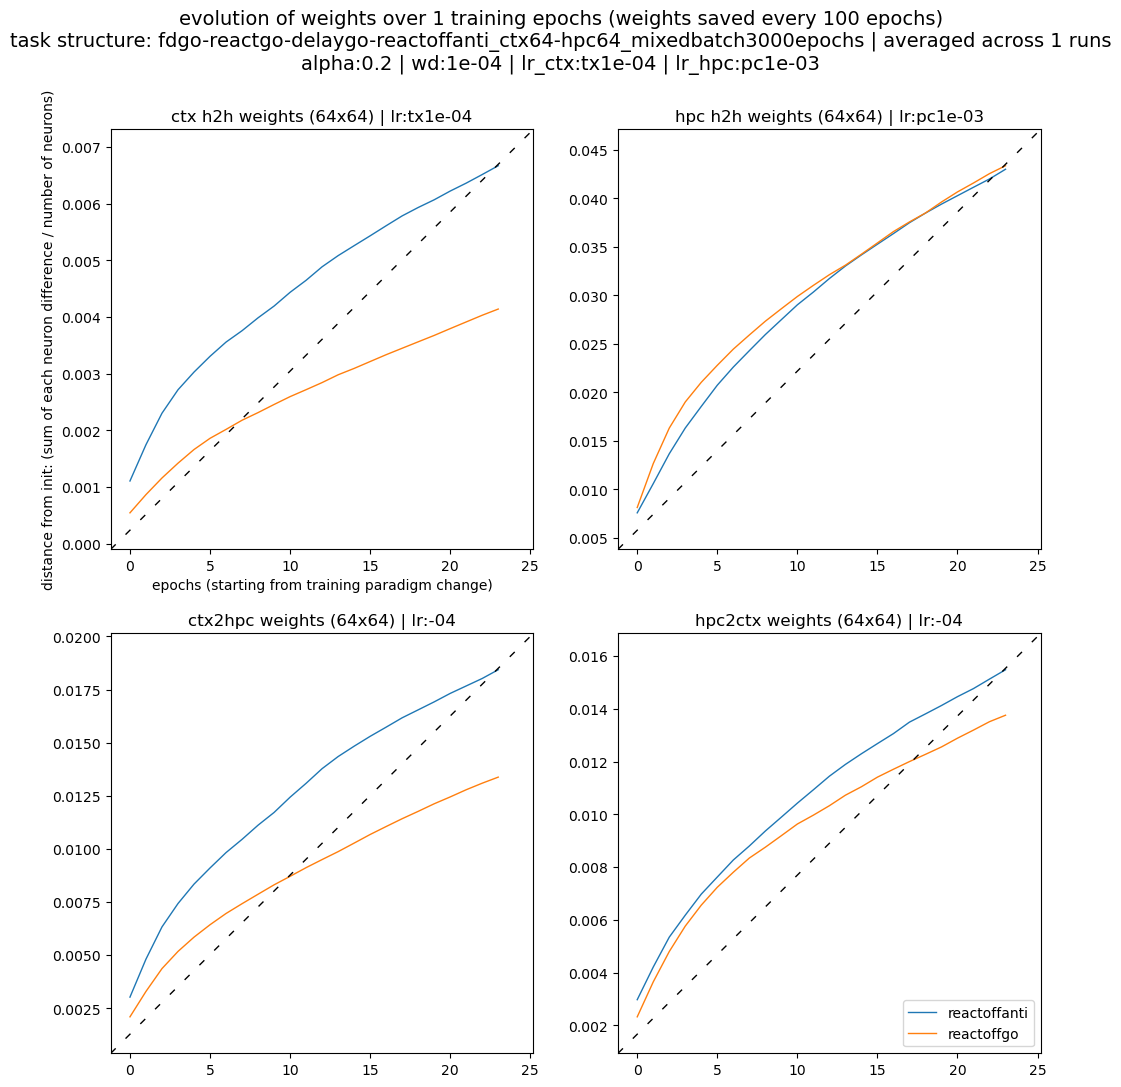

In [18]:
save_fig = False
plot_opp_weights = True
plot_avg = True
weight_plot_start = vline_loc

ctx_h2h_diffs = get_heatmap_diff_list(all_ctx_h2h_flattened, top_n, weight_plot_start, plot_avg)
hpc_h2h_diffs = get_heatmap_diff_list(all_hpc_h2h_flattened, top_n, weight_plot_start, plot_avg)
ctx2hpc_diffs = get_heatmap_diff_list(all_ctx2hpc_flattened, top_n, weight_plot_start, plot_avg)
hpc2ctx_diffs = get_heatmap_diff_list(all_hpc2ctx_flattened, top_n, weight_plot_start, plot_avg)

ctx_h2h_diffs = get_heatmap_diff_list(all_ctx_h2h_flattened, top_n, weight_plot_start, plot_avg)
hpc_h2h_diffs = get_heatmap_diff_list(all_hpc_h2h_flattened, top_n, weight_plot_start, plot_avg)
ctx2hpc_diffs = get_heatmap_diff_list(all_ctx2hpc_flattened, top_n, weight_plot_start, plot_avg)
hpc2ctx_diffs = get_heatmap_diff_list(all_hpc2ctx_flattened, top_n, weight_plot_start, plot_avg)

# xvals = len(ctx_h2h_diffs)
n_points = len(ctx_h2h_diffs)

fig, axs = plt.subplots(2, 2, figsize=(12,12)) # , aspect='equal')

axs[0][0].plot(ctx_h2h_diffs, linewidth=1, label=load_opposite)
axs[0][1].plot(hpc_h2h_diffs, linewidth=1, label=load_opposite)
axs[1][0].plot(ctx2hpc_diffs, linewidth=1, label=load_opposite)
axs[1][1].plot(hpc2ctx_diffs, linewidth=1, label=load_opposite)

if opps_loaded and plot_opp_weights:
    opp_ctx_h2h_diffs = get_heatmap_diff_list(opp_ctx_h2h_flattened, top_n, weight_plot_start, plot_avg)
    opp_hpc_h2h_diffs = get_heatmap_diff_list(opp_hpc_h2h_flattened, top_n, weight_plot_start, plot_avg)
    opp_ctx2hpc_diffs = get_heatmap_diff_list(opp_ctx2hpc_flattened, top_n, weight_plot_start, plot_avg)
    opp_hpc2ctx_diffs = get_heatmap_diff_list(opp_hpc2ctx_flattened, top_n, weight_plot_start, plot_avg)

    axs[0][0].plot(opp_ctx_h2h_diffs, linewidth=1, label=opp_list)
    axs[0][1].plot(opp_hpc_h2h_diffs, linewidth=1, label=opp_list)
    axs[1][0].plot(opp_ctx2hpc_diffs, linewidth=1, label=opp_list)
    axs[1][1].plot(opp_hpc2ctx_diffs, linewidth=1, label=opp_list)



### Graph Cosmetics ###
# axs[0,0].axvline(x = vline_loc, ls='--', color = 'r' , label = 'train paradigm change')
# axs[0,1].axvline(x = vline_loc, ls='--', color = 'r' , label = 'train paradigm change')
# axs[1,0].axvline(x = vline_loc, ls='--', color = 'r' , label = 'train paradigm change')
# axs[1,1].axvline(x = vline_loc, ls='--', color = 'r' , label = 'train paradigm change')

# ax0_ymax = axs[0,0].get_ylim()[1]
# axs[0,0].plot(ax0_ymax)
axs[0,0].axline((0, axs[0,0].get_ylim()[0]), (n_points, axs[0,0].get_ylim()[1]), \
                ls='--', dashes=(5, 10), color='black', linewidth=1)
axs[0,1].axline((0, axs[0,1].get_ylim()[0]), (n_points, axs[0,1].get_ylim()[1]), \
                ls='--', dashes=(5, 10), color='black', linewidth=1)
axs[1,0].axline((0, axs[1,0].get_ylim()[0]), (n_points, axs[1,0].get_ylim()[1]), \
                ls='--', dashes=(5, 10), color='black', linewidth=1)
axs[1,1].axline((0, axs[1,1].get_ylim()[0]), (n_points, axs[1,1].get_ylim()[1]), \
                ls='--', dashes=(5, 10), color='black', linewidth=1)

fig.suptitle('evolution of weights over '+str(len(all_ctx_h2h_flattened))+\
             ' training epochs (weights saved every '+str(weight_save_int)+' epochs)\n' \
            'task structure: '+tasknames+' | averaged across '+str(top_n)+' runs\n' \
            'alpha:'+a_str[1:]+' | wd:'+wd_str[2:]+' | lr_ctx:'+ctx_lr_str[3:]+' | lr_hpc:'+hpc_lr_str[3:], \
            fontsize=14)

axs[0,0].set_title('ctx h2h weights ('+str(ctx_size)+'x'+str(hpc_size)+') | lr:'+ctx_lr_str[3:])
axs[0,1].set_title('hpc h2h weights ('+str(ctx_size)+'x'+str(hpc_size)+') | lr:'+hpc_lr_str[3:])
axs[1,0].set_title('ctx2hpc weights ('+str(ctx_size)+'x'+str(hpc_size)+') | lr:'+c2h_lr_str[7:])
axs[1,1].set_title('hpc2ctx weights ('+str(ctx_size)+'x'+str(hpc_size)+') | lr:'+h2c_lr_str[7:])

axs[0,0].set_xlabel('epochs (starting from training paradigm change)')# (red line at delay task inclusion)')
axs[0,0].set_ylabel('distance from init: (sum of each neuron difference / number of neurons)')

plt.legend(loc='lower right')

## PCA Evals

### helper funcs & processing

In [13]:
def euclidean_distance(point1, point2):
    """
    Calculates the Euclidean distance between two N-dimensional points.
    Points can be lists or numpy arrays.
    """
    point1 = np.asarray(point1)
    point2 = np.asarray(point2)
    return np.linalg.norm(point1 - point2)

def discrete_frechet_distance(trajectory1, trajectory2):
    """
    Calculates the discrete Fréchet distance between two N-dimensional trajectories.

    Args:
        trajectory1 (list of lists or numpy array): The first trajectory.
                     Each inner list/row represents an N-dimensional point.
                     Example: [[x1, y1], [x2, y2]] or np.array([[x1, y1], [x2, y2]])
        trajectory2 (list of lists or numpy array): The second trajectory.

    Returns:
        float: The discrete Fréchet distance between the two trajectories.
    """

    # Convert trajectories to numpy arrays for consistent handling
    T1 = np.asarray(trajectory1)
    T2 = np.asarray(trajectory2)

    n = len(T1)
    m = len(T2)

    if n == 0 or m == 0:
        raise ValueError("Trajectories cannot be empty.")
    if T1.shape[1] != T2.shape[1]:
        raise ValueError("Trajectories must have the same number of dimensions (N).")

    # Initialize the cost matrix (memoization table)
    # np.inf is used for uncomputed values
    D = np.full((n, m), -1.0) # Using -1.0 to indicate uncomputed, will replace with np.inf if needed

    def calculate_path_cost(i, j):
        """
        Recursive helper function to compute the Fréchet distance for sub-trajectories.
        Uses memoization (the D matrix) to avoid redundant calculations.
        """
        if D[i, j] > -1.0: # Check if already computed
            return D[i, j]

        # Calculate the distance between the current points
        dist_ij = euclidean_distance(T1[i], T2[j])

        if i == 0 and j == 0:
            D[i, j] = dist_ij
        elif i == 0:
            # First row: constrained to move only along T2
            D[i, j] = max(dist_ij, calculate_path_cost(0, j - 1))
        elif j == 0:
            # First column: constrained to move only along T1
            D[i, j] = max(dist_ij, calculate_path_cost(i - 1, 0))
        else:
            # General case: take the minimum of the three possible previous states
            # and combine with the current point distance
            D[i, j] = max(dist_ij,
                          min(calculate_path_cost(i - 1, j),
                              calculate_path_cost(i, j - 1),
                              calculate_path_cost(i - 1, j - 1)))
        return D[i, j]

    return calculate_path_cost(n - 1, m - 1)

In [14]:
def get_pairwise_hid_dists(all_hids, task_list_unique, dist_type='euc', batches=True):
    # if in batches, shape: (4, 64, 20, 64) = (n_tasks, batch size, timesteps, neurons)
    all_dists = []
    labels = []
    n_tasks = len(task_list_unique)

    for i in range(n_tasks-1):
        i_hids = all_hids[i]
        
        for j in range(n_tasks-i-1):
            j_hids = all_hids[j+i+1]

            if dist_type=='frechet':
                dists = []
                for z in range(len(i_hids)):
                    d = discrete_frechet_distance(i_hids[z], j_hids[z])
                    dists.append(d)
                all_dists.append(np.asarray(dists).mean())
            else: # if dist_type=='euclidean':
                raw_diff = np.absolute(i_hids - j_hids) # abs of the differences
                dists = (raw_diff).sum(axis=-1).mean(axis=0) # sum all the neurons, mean across batches
                all_dists.append(dists)



            label_str = '-'.join((task_list_unique[i], task_list_unique[j+i+1]))
            labels.append(label_str)

        if i==(n_tasks-1): break

    return all_dists, labels


def get_pairwise_pca_dists(all_coords, task_list_unique, batches=True):
    # if in batches, shape: (4, 64, 20, 64)

    n_tasks = len(task_list_unique)
    # n_combs = math.comb(n_tasks, 2) # (n_tasks*(n_tasks-1)) / 2
    all_dists = []
    labels = []

    ## iterate thru all pairwise combinations of the coord list
    for i in range(n_tasks-1):

        i_coords = all_coords[i]
        for j in range(n_tasks-i-1):

            j_coords = all_coords[j+i+1]
            dists = [math.dist(i_coords[t], j_coords[t]) for t in range(len(i_coords))]
            all_dists.append(dists)

            label_str = '-'.join((task_list_unique[i], task_list_unique[j+i+1]))
            labels.append(label_str)

        # all_dists.append(dist_list)
        if i==(n_tasks-1): break

    return all_dists, labels


def get_hid_pca(hids, n_comps=None):

    # assuming shape: (#tasks, #batches, #time, #neurons) (4, 64, 20, 64)
    full_hid_shape = np.asarray(hids).shape
    n_tasks = full_hid_shape[0]
    batch_size = full_hid_shape[1]
    tdim = full_hid_shape[2]

    pca_batched_hids = []
    for i in range(full_hid_shape[1]): # for each batch

        this_batch = np.asarray(hids[:,i,:,:])
        pca_ready = this_batch.reshape(-1, full_hid_shape[-1])
        if n_comps==None: pca_applied = PCA().fit_transform(np.asarray(pca_ready)) # n_components=2
        else: pca_applied = PCA(n_components=n_comps).fit_transform(np.asarray(pca_ready)) # n_components=2
        pca_batched_hids.append(pca_applied)

    pca_batched_hids = np.asarray(pca_batched_hids).reshape(batch_size, n_tasks, tdim, -1)
    return pca_batched_hids

### PCA processing

In [15]:
batch_num = 0 # which batch to get for pca
n_comps = None
dist_type = 'euc' # 'frechet'

pca_batched_ctx_hids = get_hid_pca(inf_all_ctx_hids, n_comps)
pca_batched_hpc_hids = get_hid_pca(inf_all_hpc_hids, n_comps)
print('post PCA shape:         ', pca_batched_ctx_hids.shape)

components_inf_ctx = pca_batched_ctx_hids[batch_num]
components_inf_hpc = pca_batched_hpc_hids[batch_num]
print('single batch PCA shape: ', np.asarray(components_inf_ctx).shape)

dists_ctx, dist_lbls_ctx = get_pairwise_hid_dists(inf_all_ctx_hids, task_list_unique, dist_type=dist_type)
dists_hpc, dist_lbls_hpc = get_pairwise_hid_dists(inf_all_hpc_hids, task_list_unique, dist_type=dist_type)
print('pairwise dist df shape: ', np.asarray(dists_ctx).shape)
dists_ctx_frechet, dist_lbls_ctx_frechet = get_pairwise_hid_dists(inf_all_ctx_hids, task_list_unique, dist_type='frechet')
dists_hpc_frechet, dist_lbls_hpc_frechet = get_pairwise_hid_dists(inf_all_hpc_hids, task_list_unique, dist_type='frechet')
# print('pairwise dist df shape: ', np.asarray(dists_ctx).shape)

dists_pca_ctx, dist_pca_lbls_ctx = get_pairwise_hid_dists(pca_batched_ctx_hids, task_list_unique, dist_type=dist_type)
dists_pca_hpc, dist_pca_lbls_hpc = get_pairwise_hid_dists(pca_batched_hpc_hids, task_list_unique, dist_type=dist_type)
print('pairwise pca dist df shape: ', np.asarray(dists_pca_ctx).shape)

if opps_loaded:
    print('opps loaded')
    pca_batched_opp_ctx_hids = get_hid_pca(inf_all_opp_ctx_hids, n_comps)
    pca_batched_opp_hpc_hids = get_hid_pca(inf_all_opp_hpc_hids, n_comps)

    components_inf_opp_ctx = pca_batched_opp_ctx_hids[batch_num]
    components_inf_opp_hpc = pca_batched_opp_hpc_hids[batch_num]
    print(np.asarray(components_inf_opp_ctx).shape)

    dists_opp_ctx, dist_lbls_opp_ctx = get_pairwise_hid_dists(inf_all_opp_ctx_hids, task_list_unique, dist_type=dist_type)
    dists_opp_hpc, dist_lbls_opp_hpc = get_pairwise_hid_dists(inf_all_opp_hpc_hids, task_list_unique, dist_type=dist_type)
    dists_opp_ctx_frechet, dist_opp_lbls_ctx_frechet = get_pairwise_hid_dists(inf_all_ctx_hids, task_list_unique, dist_type='frechet')
    dists_opp_hpc_frechet, dist_opp_lbls_hpc_frechet = get_pairwise_hid_dists(inf_all_hpc_hids, task_list_unique, dist_type='frechet')

    dists_pca_opp_ctx, dist_pca_opp_lbls_ctx = get_pairwise_hid_dists(components_inf_opp_ctx, task_list_unique, dist_type=dist_type)
    dists_pca_opp_hpc, dist_pca_opp_lbls_hpc = get_pairwise_hid_dists(components_inf_opp_hpc, task_list_unique, dist_type=dist_type)



post PCA shape:          (64, 5, 40, 64)
single batch PCA shape:  (5, 40, 64)
pairwise dist df shape:  (10, 40)
pairwise pca dist df shape:  (10, 40)


In [16]:
if dist_type == 'frechet':
    for i, lbl in enumerate(dist_lbls_ctx): 
        print(lbl)
        print(dists_ctx[i], dists_hpc[i])
        print()
        

### 2D PCA

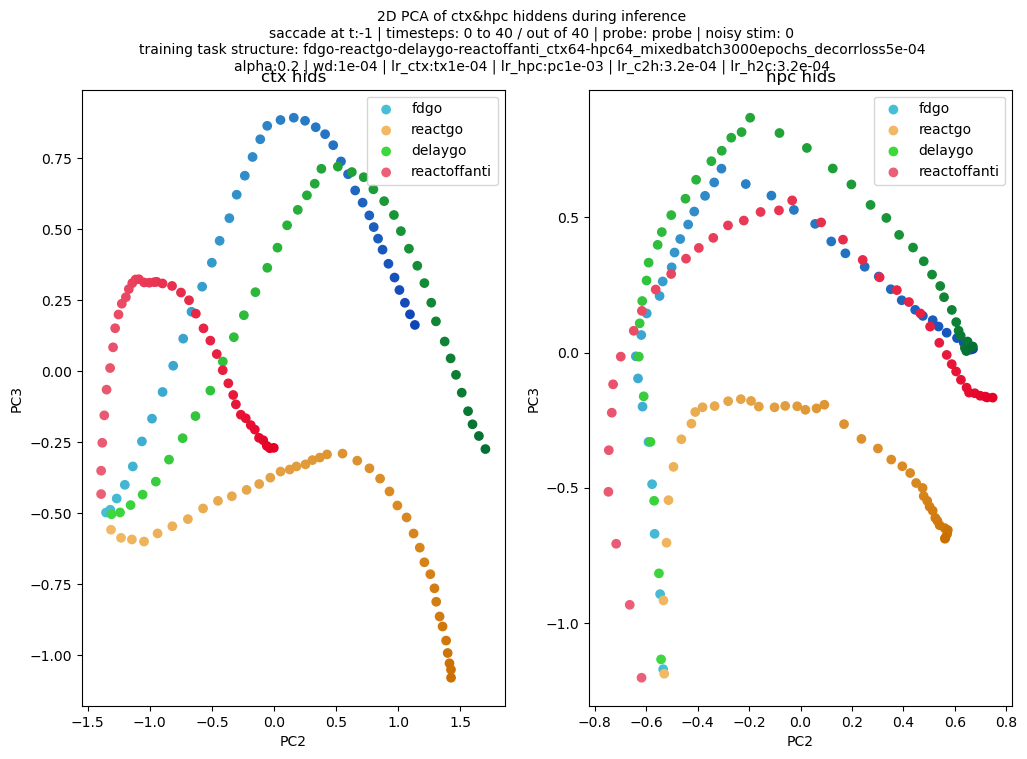

In [ ]:
color_pairs = [['#46BFD5', '#1045B8'], ['#F1B963', '#CB6F00'], # blue, gold
               ['#3ED83E', '#057033'], ['#EB6077', '#E60026'], # green, red
               ['#EC6EF0', '#820187']] # purple


overlay_pca = True # overlay all the tasks on top of eachother
plot_pca_opps = False # plot the opposite one as well
pc1 = 1
pc2 = 2
save_fig = False

hid_shape = np.asarray(components_inf_ctx[0]).shape # (4, 20, 4096)
offset_start = 0 # y_react # hid_shape[0]-20
offset_end =  hid_shape[0]
remaining_len = offset_end - offset_start

## Create a figure with two subplots
fig = plt.figure(figsize=(12,8)) # figsize=(11,9) # figsize=plt.figaspect(0.5)

## Add the first subplot with 3D projection
ax1 = fig.add_subplot(1, 2, 1) # , projection='3d')
ax2 = fig.add_subplot(1, 2, 2) # , projection='3d')

for i,task in enumerate(task_list_unique):
    ### ----- get x and y coords for this task ----- ###
    xs_ctx = [a[pc1] for a in components_inf_ctx[i]]
    ys_ctx = [a[pc2] for a in components_inf_ctx[i]]
    # zs_ctx = [a[pc3] for a in components_inf_ctx[i]]
    xs_hpc = [a[pc1] for a in components_inf_hpc[i]]
    ys_hpc = [a[pc2] for a in components_inf_hpc[i]]
    # zs_hpc = [a[pc3] for a in components_inf_hpc[i]]


    ax1.scatter(xs_ctx, ys_ctx, color=get_color_gradient(color_pairs[i][0], color_pairs[i][1], len(xs_ctx)), label=task) # , c=z, cmap='cividis');
    ax2.scatter(xs_hpc, ys_hpc, color=get_color_gradient(color_pairs[i][0], color_pairs[i][1], len(xs_hpc)), label=task) # , c=z, cmap='cividis');


fig.suptitle('2D PCA of ctx&hpc hiddens during inference\n'
        'saccade at t:'+str(y_react)+' | timesteps: '+str(offset_start)+' to '+str(offset_end)+' / out of '+str(hid_shape[0])+ 
        ' | probe: '+str(hp['probe']) + ' | noisy stim: ' + str(hp['no_stim']) + 
        '\ntraining task structure: '+tasknames+ # ' | averaged across '+str(top_n)+' runs\n' \
        '\nalpha:'+a_str[1:]+' | wd:'+wd_str[2:]+' | lr_ctx:'+ctx_lr_str[3:]+' | lr_hpc:'+hpc_lr_str[3:]+
        ' | lr_c2h:'+c2h_lr_str[3:]+' | lr_h2c:'+h2c_lr_str[3:]+
        # '\nblue (start) to red (end) gradient'
        '', fontsize=10)

# fig.supxlabel('PC'+str(pc1+1))
ax1.title.set_text('ctx hids')
ax2.title.set_text('hpc hids')
ax1.set_xlabel('PC'+str(pc1+1)); ax1.set_ylabel('PC'+str(pc2+1)) # ; ax1.set_zlabel('PC'+str(pc3+1))
ax2.set_xlabel('PC'+str(pc1+1)); ax2.set_ylabel('PC'+str(pc2+1)) # ; ax2.set_zlabel('PC'+str(pc3+1))
ax1.legend(); ax2.legend()

if save_fig:
    fig_name = '2dPCA_inf.png' # PC'+str(pc1+1) + 'x' + 'PC'+str(pc1+2) + '
    fig.savefig(os.path.join(figs_dir, task_paradigm, fig_name))

### 3D PCA (FIGS IN PAPER)

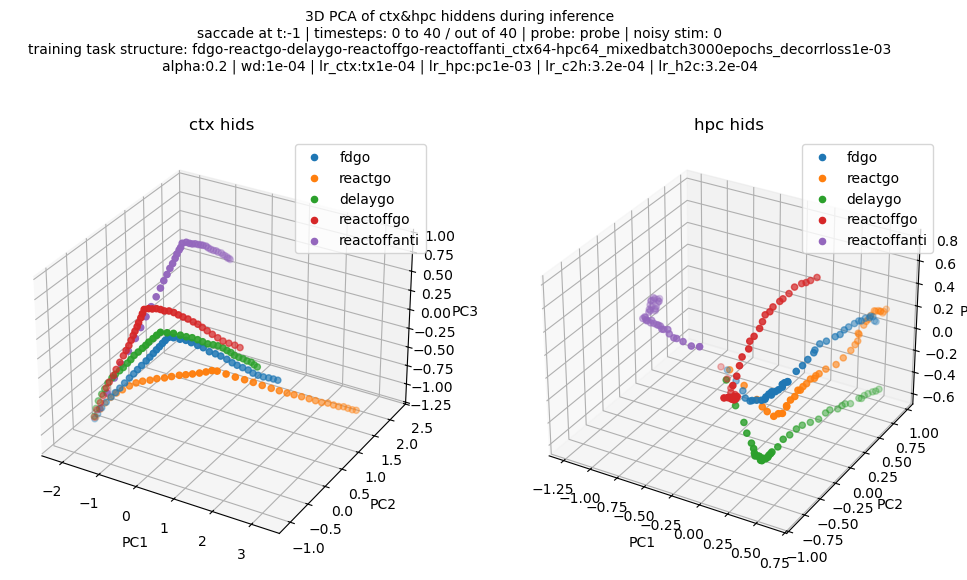

In [17]:
from mpl_toolkits.mplot3d import Axes3D

overlay_pca = True # overlay all the tasks on top of eachother
plot_pca_opps = False # plot the opposite one as well
pc1 = 0
pc2 = 1
pc3 = 2
save_fig = False

hid_shape = np.asarray(components_inf_ctx[0]).shape # (4, 20, 4096)
offset_start = 0 # y_react # hid_shape[0]-20
offset_end =  hid_shape[0]
remaining_len = offset_end - offset_start

## Create a figure with two subplots
fig = plt.figure(figsize=(12,7)) # figsize=(11,9) # figsize=plt.figaspect(0.5)

## Add the first subplot with 3D projection
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')

for i,task in enumerate(task_list_unique):
    ### ----- get x and y coords for this task ----- ###
    xs_ctx = [a[pc1] for a in components_inf_ctx[i]]
    ys_ctx = [a[pc2] for a in components_inf_ctx[i]]
    zs_ctx = [a[pc3] for a in components_inf_ctx[i]]
    xs_hpc = [a[pc1] for a in components_inf_hpc[i]]
    ys_hpc = [a[pc2] for a in components_inf_hpc[i]]
    zs_hpc = [a[pc3] for a in components_inf_hpc[i]]

    ax1.scatter3D(xs_ctx, ys_ctx, zs_ctx, label=task) # , c=z, cmap='cividis');
    ax2.scatter3D(xs_hpc, ys_hpc, zs_hpc, label=task) # , c=z, cmap='cividis');


fig.suptitle('3D PCA of ctx&hpc hiddens during inference\n'
        'saccade at t:'+str(y_react)+' | timesteps: '+str(offset_start)+' to '+str(offset_end)+' / out of '+str(hid_shape[0])+ 
        ' | probe: '+str(hp['probe']) + ' | noisy stim: ' + str(hp['no_stim']) + 
        '\ntraining task structure: '+tasknames+ # ' | averaged across '+str(top_n)+' runs\n' \
        '\nalpha:'+a_str[1:]+' | wd:'+wd_str[2:]+' | lr_ctx:'+ctx_lr_str[3:]+' | lr_hpc:'+hpc_lr_str[3:]+
        ' | lr_c2h:'+c2h_lr_str[3:]+' | lr_h2c:'+h2c_lr_str[3:]+
        # '\nblue (start) to red (end) gradient'
        '', fontsize=10)

# fig.supxlabel('PC'+str(pc1+1))
ax1.title.set_text('ctx hids')
ax2.title.set_text('hpc hids')
ax1.set_xlabel('PC'+str(pc1+1)); ax1.set_ylabel('PC'+str(pc2+1)); ax1.set_zlabel('PC'+str(pc3+1))
ax2.set_xlabel('PC'+str(pc1+1)); ax2.set_ylabel('PC'+str(pc2+1)); ax2.set_zlabel('PC'+str(pc3+1))
ax1.legend(); ax2.legend()

if save_fig:
    fig_name = '3dPCA_inf.png' # PC'+str(pc1+1) + 'x' + 'PC'+str(pc1+2) + '
    fig.savefig(os.path.join(figs_dir, task_paradigm, fig_name))

### Pairwise dists (FIGS IN PAPER)

In [18]:
overlay_pca = True # overlay all the tasks on top of eachother
plot_pca_opps = False # plot the opposite one as well
save_fig = False
use_raw_activations = True
same_scale = False

plot_type = 'raw' # pca or raw


if plot_type=='raw':
    ctx_dists = dists_ctx
    hpc_dists = dists_hpc
    if plot_pca_opps:
        ctx_dists_opp = dists_opp_ctx
        hpc_dists_opp = dists_opp_hpc
elif plot_type=='pca':
    ctx_dists = dists_pca_ctx
    hpc_dists = dists_pca_hpc
    if plot_pca_opps:
        ctx_dists_opp = dists_pca_opp_ctx
        hpc_dists_opp = dists_pca_opp_hpc
else: print('INVALID PLOT TYPE')

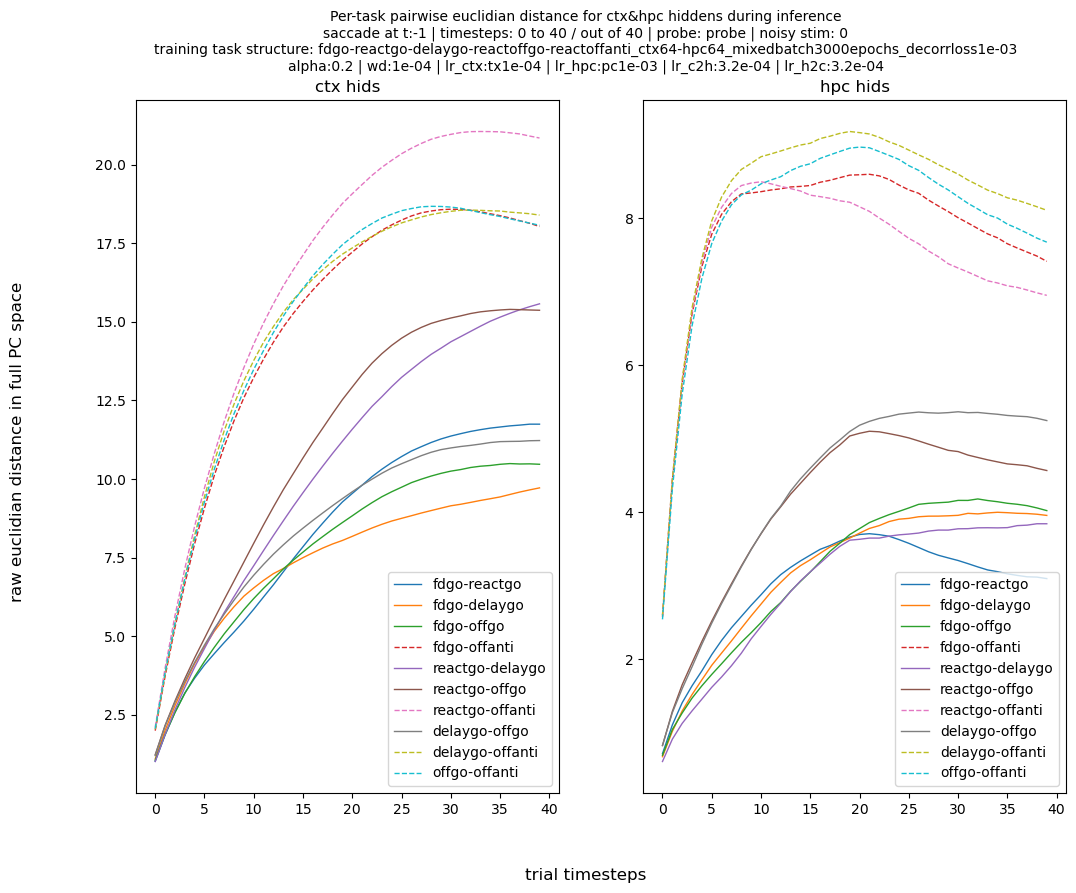

In [19]:

## Plotting
if dist_type=='euc':

    max_y = max(max(map(max, ctx_dists)), max(map(max, hpc_dists)))
    max_y = 5 * math.ceil(max_y / 5)

    if plot_pca_opps: fig, axs = plt.subplots(2, 2, figsize=(12,12)) # , aspect='equal')
    else: fig, axs = plt.subplots(1, 2, figsize=(12,9)) # , aspect='equal')

    for i in range(math.comb(len(task_list_unique), 2)):

        if plot_pca_opps:
            axs[0,0].plot(ctx_dists[i], linewidth=1, label=dist_lbls_ctx[i])
            axs[0,1].plot(hpc_dists[i], linewidth=1, label=dist_lbls_hpc[i])
            axs[1,0].plot(ctx_dists_opp[i], linewidth=1, label=dist_lbls_opp_ctx[i])
            axs[1,1].plot(hpc_dists_opp[i], linewidth=1, label=dist_lbls_opp_hpc[i])
        else:
            if 'anti' in dist_lbls_ctx[i]: linestyle='dashed'
            else: linestyle='solid'
            
            dist_lbls_ctx[i] = dist_lbls_ctx[i].replace('reactoff', 'off')
            axs[0].plot(ctx_dists[i], linewidth=1, linestyle=linestyle, label=dist_lbls_ctx[i])
            axs[1].plot(hpc_dists[i], linewidth=1, linestyle=linestyle, label=dist_lbls_ctx[i])

    if plot_pca_opps:
        axs[0,0].title.set_text('ctx hids')
        axs[0,1].title.set_text('hpc hids')
        axs[0,0].set_ylabel('with '+load_opposite)
        axs[1,0].set_ylabel('with '+opposite_dict[load_opposite])
        axs[0,0].legend(); axs[0,1].legend(); axs[1,0].legend(); axs[1,1].legend()
    else:
        axs[0].title.set_text('ctx hids')
        axs[1].title.set_text('hpc hids')
        axs[0].legend(); axs[1].legend()


    fig.suptitle('Per-task pairwise euclidian distance for ctx&hpc hiddens during inference\n'
            'saccade at t:'+str(y_react)+' | timesteps: '+str(offset_start)+' to '+str(offset_end)+' / out of '+str(hid_shape[0])+ 
            ' | probe: '+str(hp['probe']) + ' | noisy stim: ' + str(hp['no_stim']) + 
            '\ntraining task structure: '+tasknames+ # ' | averaged across '+str(top_n)+' runs\n' \
            '\nalpha:'+a_str[1:]+' | wd:'+wd_str[2:]+' | lr_ctx:'+ctx_lr_str[3:]+' | lr_hpc:'+hpc_lr_str[3:]+
            ' | lr_c2h:'+c2h_lr_str[3:]+' | lr_h2c:'+h2c_lr_str[3:]+
            '', fontsize=10)
    fig.supxlabel('trial timesteps')
    fig.supylabel('raw euclidian distance in full PC space')
    if same_scale: 
        for ax in axs: ax.set_ylim(0, max_y)
    plt.show()

    if save_fig:
        fig_name = 'pairwise-dists_inf.png'
        fig.savefig(os.path.join(figs_dir, task_paradigm, fig_name))

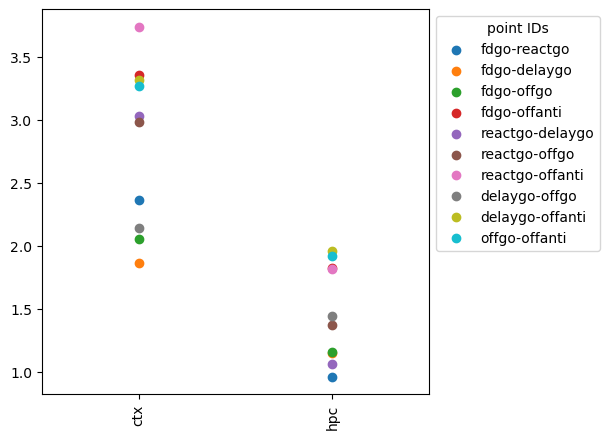

In [20]:
# if dist_type=='frechet': 

fig, ax = plt.subplots(1, 1, figsize=(5,5)) # , aspect='equal')

n_points = len(dists_ctx_frechet)
xticklabels = ['ctx', 'hpc']
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] # ['blue', 'yellow', 'green', 'red', 'purple', 'brown']

for i, txt in enumerate(dist_lbls_ctx):
    s1 = ax.scatter(0, dists_ctx_frechet[i], c=colors[i], label=txt)
    s2 = ax.scatter(1, dists_hpc_frechet[i], c=colors[i]) # , label=txt)


plt.xlim(-0.5, 1.5)
ax.set_xticks([0,1], xticklabels, rotation='vertical')
ax.legend(ncol=1, bbox_to_anchor=(1, 1), loc='upper left', title='point IDs')

plt.show()

## Hid2Out weight analyses (unused)

In [ ]:
print(np.asarray(all_ctx2out_weights).shape)
print(np.asarray(all_hpc2out_weights).shape)
 #  shape = (1, 40, 33, 64), (each specific model x number of weight saves x n_out x n_hid)

(1, 15, 33, 64)
(1, 15, 33, 64)


In [ ]:
model_num = 0
save_num = -1
zero_sens = 1e-3

ctx2out_weights = all_ctx2out_weights[model_num][save_num]
hpc2out_weights = all_hpc2out_weights[model_num][save_num]
print('single ctx2out weight df shape: ', (ctx2out_weights).shape)

ctx2out_weights_flattened = ctx2out_weights.flatten()
hpc2out_weights_flattened = hpc2out_weights.flatten()
print('total number of weights: ', len(ctx2out_weights_flattened)); print()


print('CTX2OUT stats:')
print('avg: ', np.mean(ctx2out_weights_flattened), 
      ' | std: ', np.std(ctx2out_weights_flattened), 
      ' | max: ', np.max(ctx2out_weights_flattened), 
      ' | min: ', np.min(ctx2out_weights_flattened), )

ctx2out_nonzero = ctx2out_weights_flattened[(ctx2out_weights_flattened<zero_sens) & (ctx2out_weights_flattened>-zero_sens)]
print('# of weights between +/-' + str(zero_sens) + ': ' + str(len(ctx2out_nonzero)))


print('\nHPC2OUT stats:')
print('avg: ', np.mean(hpc2out_weights_flattened), 
      ' | std: ', np.std(hpc2out_weights_flattened), 
      ' | max: ', np.max(hpc2out_weights_flattened), 
      ' | min: ', np.min(hpc2out_weights_flattened), )

hpc2out_nonzero = hpc2out_weights_flattened[(hpc2out_weights_flattened<zero_sens) & (hpc2out_weights_flattened>-zero_sens)]
print('# of weights between +/-' + str(zero_sens) + ': ' + str(len(hpc2out_nonzero)))

# np.count_nonzero(ctx2out_weights_flattened)

single ctx2out weight df shape:  (33, 64)
total number of weights:  2112

CTX2OUT stats:
avg:  -0.00908502  | std:  0.14619718  | max:  0.29560488  | min:  -0.31452298
# of weights between +/-0.001: 211

HPC2OUT stats:
avg:  -0.16426049  | std:  0.32184705  | max:  1.1308063  | min:  -1.3253255
# of weights between +/-0.001: 422


## LESION EXPERIMENTS

### performance stat helpers

In [74]:
def get_lesion_perf_stats(base_perfs, lesion_perfs, task_list):
    # base perfs shape: (n_tasks)
    # lesion perfs shape: (n_tasks, n_neurons)
    all_post_lesion_diffs = []
    
    for i,task in enumerate(task_list):
        task_base_perf = base_perfs[i]
        task_lesioned_perfs = lesion_perfs[i]

        task_post_lesion_diffs = []
        for j,perf in enumerate(task_lesioned_perfs):
            diff = np.abs(task_base_perf - perf)
            task_post_lesion_diffs.append(diff)

        all_post_lesion_diffs.append(task_post_lesion_diffs)

    return all_post_lesion_diffs


In [75]:

def modify_activation_hook(neuron_idx, val, n_neurons):
    def _modify_activation_hook(module, input, output):
        print(output[neuron_idx][:])
        output[neuron_idx][:] = torch.tensor([val]*n_neurons)
        print(output[neuron_idx][:])
        return output
    return _modify_activation_hook

og_activations = {}
def modify_activation_prehook(region, neuron_idx, val): # , n_neurons):
    def pre_hook(module, input):
        x = input[0].clone()
        og_activations[region+str(neuron_idx)] = x.clone()
        print(x[0,neuron_idx])
        x[0,neuron_idx] = val

        with torch.no_grad(): true_out = module(x)



        return (x,)
    return pre_hook

def modify_activation_posthook(region, neuron_idx, val):
    def post_hook(module, input, output):
        output[0,neuron_idx] = og_activations[region+str(neuron_idx)][0,neuron_idx]
        print("output after forward: ", output)
        return output
    return post_hook

In [76]:
        # print(i)
        # print(torch.sum(model.h2h_ctx.weight.data[i][:]))
        # model.h2h_ctx.weight.data = weights_saved

        # ## save the original tensor
        # ctx_tensor_saved = model_ctx_exp.h2h_ctx.weight.data[j][:].detach().clone()
        # hpc_tensor_saved = model_hpc_exp.h2h_ctx.weight.data[j][:].detach().clone()

        # ## zero the outputs
        # model_ctx_exp.h2h_ctx.weight.data[j][:] = torch.tensor([0]*n_neurons)
        # model_hpc_exp.h2h_hpc.weight.data[j][:] = torch.tensor([0]*n_neurons)

        # ## register hooks to zero neuron activation
        # og_activations = {}
        # prehook_ctx = model_ctx_exp.h2h_ctx.register_forward_pre_hook(modify_activation_prehook('ctx', j, 0))
        # prehook_hpc = model_hpc_exp.h2h_hpc.register_forward_pre_hook(modify_activation_prehook('hpc', j, 0))
        # posthook_ctx = model_ctx_exp.h2h_ctx.register_forward_pre_hook(modify_activation_prehook('ctx', j, 0))
        # posthook_hpc = model_hpc_exp.h2h_hpc.register_forward_pre_hook(modify_activation_prehook('hpc', j, 0))

        # hook_ctx = model_ctx_exp.h2h_ctx.register_forward_hook(modify_activation_hook(j, 0, n_neurons))
        # hook_hpc = model_hpc_exp.h2h_hpc.register_forward_hook(modify_activation_hook(j, 0, n_neurons))
        
        # ## re-assign the neuron weights
        # model_ctx_exp.h2h_ctx.weight.data[j][:] = ctx_tensor_saved
        # model_hpc_exp.h2h_ctx.weight.data[j][:] = hpc_tensor_saved

        # prehook_ctx.remove()
        # prehook_hpc.remove()
        # posthook_ctx.remove()
        # posthook_ctx.remove()

In [77]:
model_ctx_exp = copy.deepcopy(model)
model_hpc_exp = copy.deepcopy(model)

In [78]:
def outliers_modified_z_score(ys, threshold=3.5):

    ys_arr = np.array(ys)
    median_y = np.median(ys_arr)
    median_absolute_deviation_y = np.median(np.abs(ys_arr - median_y))
    modified_z_scores = 0.6745 * (ys_arr - median_y) / median_absolute_deviation_y

    return np.asarray([z for z,v in enumerate(np.abs(modified_z_scores)) if v > threshold])
    # return (ys_arr[np.abs(modified_z_scores) > threshold]).tolist()
    

def detect_iqr_outliers_robust(data, factor=1.5):
  """
  Detects outliers in a NumPy array using the Interquartile Range (IQR) method.

  Args:
    data (np.ndarray): The input NumPy array.
    factor (float): A multiplier for the IQR to determine the outlier boundaries
                    (common value is 1.5).

  Returns:
    np.ndarray: A boolean array indicating which data points are outliers.
  """
  data = np.asarray(data) # Ensure it's a NumPy array
  if data.size < 2:
    return np.array([False] * data.size) # Cannot calculate quartiles meaningfully

  q1 = np.percentile(data, 25)
  q3 = np.percentile(data, 75)
  iqr = q3 - q1
  lower_bound = q1 - factor * iqr
  upper_bound = q3 + factor * iqr
  return np.asarray([z for z,v in enumerate(data) if v > upper_bound]) 
# (data > upper_bound) # (data < lower_bound) | 


def sort_lesion_heatmap(df, func='zscore', thresh=None): # ctx_lesion_diffs
    ofunc_dict = {
        'zscore': outliers_modified_z_score,
        'iqr': detect_iqr_outliers_robust,
    }
    thresh_dict = {
        'zscore': 3.5,
        'iqr': 1.5,
    }

    outlier_func = ofunc_dict[func]
    if thresh==None: thresh=thresh_dict[func]

    n_tasks = len(df)
    df_np = np.asarray(df)

    # outlier_func(ctx_lesion_diffs[:,0], thresh)
    idx_cats = [[] for i in range(n_tasks)]
    for i in range(len(df[0])): # step thru each neuron to get max task
        idx_cats[np.argmax(df_np[:,i])].append(i)
    
    new_df = []
    transition_idxs = []
    for i in range(n_tasks): # create the full df
        if len(idx_cats[i])==0: transition_idxs.append(0); continue;
        
        df_subset = df_np[:,idx_cats[i]].T
        df_subset_sorted = np.asarray(sorted(df_subset, key=lambda row: row[i], reverse = True))

        if i==0 or sum(transition_idxs)==0: 
            transition_idxs.append(len(idx_cats[i]))
            new_df = df_subset_sorted
        else: 
            transition_idxs.append(transition_idxs[i-1] + len(idx_cats[i]))
            new_df = np.vstack((new_df, df_subset_sorted))

    return new_df, transition_idxs



def sort_lesion_heatmap_old(df, func='zscore', thresh=None): # ctx_lesion_diffs
    # ctx_lesion_diffs shape = (n_tasks, n_neurons - diff per neuron when lesioned)
    ofunc_dict = {
        'zscore': outliers_modified_z_score,
        'iqr': detect_iqr_outliers_robust,
    }
    thresh_dict = {
        'zscore': 3.5,
        'iqr': 1.5,
    }

    outlier_func = ofunc_dict[func]
    if thresh==None: thresh=thresh_dict[func]
    
    n_tasks = len(df)
    s = np.asarray(df).T

    safe_idxs = []
    transition_idxs = []

    for i in range(n_tasks):

        ## sort the df
        if i==0: sorted_indices = np.argsort(-s[:, i])
        else: 
            sorted_indices = np.argsort(-s[safe_idxs[-1]+1:, i])
            sorted_indices += len(safe_idxs)
            sorted_indices = safe_idxs + sorted_indices.tolist()
        s = s[sorted_indices] # [::-1]


        ## find which outlier indices to keep unchanged
        # q = np.quantile(df[i],thresh)
        if i==0: tmp_safe = outlier_func(s[:,i], thresh) # np.asarray([z for z,v in enumerate(s[:,i]) if v > q])
        else: 
            # print(len(s[safe_idxs[-1]+1:,i]), s[safe_idxs[-1]+1:,i])
            tmp_safe = outlier_func(s[safe_idxs[-1]+1:,i], thresh) # np.asarray([z for z,v in enumerate(s[safe_idxs[-1]+1:,i]) if v > q])

        tmp_safe += len(safe_idxs)
        safe_idxs = safe_idxs + tmp_safe.tolist()
        if i!=len(df)-1: transition_idxs.append(safe_idxs[-1]+1)
        
    return s, transition_idxs


### single neuron lesions (FIGS IN PAPER)

#### processing

In [79]:
### LESION EVERY SINGLE NEURON INDIVIDUALLY 
task_base_perfs = []; task_base_losses = []

all_ctx_exp_perfs = []; all_hpc_exp_perfs = []
all_ctx_exp_losses = []; all_hpc_exp_losses = []
all_ctx_exp_trials = []; all_hpc_exp_trials = []
all_ctx_exp_yhats = []; all_hpc_exp_yhats = []
all_ctx_exp_ctxhids = []; all_ctx_exp_hpchids = []
all_hpc_exp_ctxhids = []; all_hpc_exp_hpchids = []


hp['batch_size'] = 8
batch_size= hp['batch_size']
hp['mode'] = 'inference'
hp['tdim'] = 100
hp['y_loc'] = np.random.rand(batch_size)*2*np.pi
hp['probe']= 'fixed'

# hp['no_stim'] = 0 # have a stimulus bump or not
# hp['probe'] = 1 # probe the network or not
# hp['tdim'] = 40 # if want to fix the tdim; comment out if not
# hp['fxtn_val'] = 0.5 # fxtn val = -1 means work as normal, 0,1=0,1 respectively; 0.5 = 1 then 0

n_lesions = 1
n_reps = 1


lesion_layer = 'h2h' # h2h and output
lesion_type = 'mask' # mask and hook


if lesion_layer=='h2h': 
    n_neurons = model.h2h_ctx.out_features
    n_neurons_hpc = model.h2h_hpc.out_features
    ctx_weights_saved = model.h2h_ctx.weight.data.detach().clone()
    hpc_weights_saved = model.h2h_ctx.weight.data.detach().clone()
elif lesion_layer=='output': 
    n_neurons = model.ctx2out.out_features
    ctx_weights_saved = model.ctx2out.weight.data.detach().clone()
    hpc_weights_saved = model.h2h_ctx.weight.data.detach().clone()



## For each task
for i,task in tqdm(enumerate(task_list_unique)):
    print('running: ', task)
    trials = [generate_trials(task, hp, 'random', batch_size=hp['batch_size']) for _ in range(n_reps)]

    ## Get the base task perf w/o lesion
    repped_perf = []
    for n in range(1):
        (base_perf, base_losses), base_hids, base_trial, base_y_react \
            = run_model_inference(model, task, hp, inf_trial=trials[n]) # , time_bounds)
        repped_perf.append(base_perf*100)
    task_base_perfs.append(np.mean(repped_perf)) # ; task_base_losses.append(base_losses)

    ## Loop thru each neuron for lesioning
    ctx_exp_perfs = []; ctx_exp_losses = []
    hpc_exp_perfs = []; hpc_exp_losses = []
    ctx_exp_trials = []; hpc_exp_trials = []
    ctx_exp_yhats = []; hpc_exp_yhats = []
    ctx_exp_ctxhids = []; ctx_exp_hpchids = []
    hpc_exp_ctxhids = []; hpc_exp_hpchids = []
    for j in range(n_neurons):
        # repped_perfs = []
        ctx_perfs = []
        hpc_perfs = []

        ## run inference n_reps number of times for average
        # lesion_idxs = sorted(random.sample(range(0, n_neurons), n_lesions))
        for n in range(n_reps): # , inf_trial=all_ctx_exp_trials_store[i][j] # inf_trial=all_ctx_exp_trials_store[i][j],
            (perf_ctx, losses, yhats_ctx), hids_ctx, trial_ctx, y_react \
                = run_model_inference(model_ctx_exp, task, hp, inf_trial=trials[n], lesion=([j],'ctx', lesion_layer, lesion_type), return_y=True)
            ctx_perfs.append(perf_ctx*100)
            
            if j < n_neurons_hpc:
                (perf_hpc, losses, yhats_hpc), hids_hpc, trial_hpc, y_react \
                    = run_model_inference(model_hpc_exp, task, hp, inf_trial=trials[n], lesion=([j],'hpc', lesion_layer, lesion_type), return_y=True)
                hpc_perfs.append(perf_hpc*100)
            # repped_perfs.append([perf_ctx*100,perf_hpc*100])


        ctx_exp_perfs.append(np.mean(ctx_perfs))# ; ctx_exp_losses.append(losses) # [r[0] for r in repped_perfs]
        ctx_exp_trials.append(trial_ctx); ctx_exp_yhats.append(yhats_ctx)
        ctx_exp_ctxhids.append(hids_ctx[0]); ctx_exp_hpchids.append(hids_ctx[1])

        if j < n_neurons_hpc:
            hpc_exp_perfs.append(np.mean(np.mean(hpc_perfs))) # [r[1] for r in repped_perfs]))# ; hpc_exp_losses.append(losses)
            hpc_exp_trials.append(trial_hpc)
            hpc_exp_yhats.append(yhats_hpc)
            hpc_exp_ctxhids.append(hids_ctx[0])
            hpc_exp_hpchids.append(hids_ctx[1])


    all_ctx_exp_perfs.append(ctx_exp_perfs); all_ctx_exp_losses.append(ctx_exp_losses)
    all_hpc_exp_perfs.append(hpc_exp_perfs); all_hpc_exp_losses.append(hpc_exp_losses)
    all_ctx_exp_trials.append(ctx_exp_trials); all_hpc_exp_trials.append(hpc_exp_trials)
    all_ctx_exp_yhats.append(ctx_exp_yhats); all_hpc_exp_yhats.append(hpc_exp_yhats)
    all_ctx_exp_ctxhids.append(ctx_exp_ctxhids); all_ctx_exp_hpchids.append(ctx_exp_hpchids)
    all_hpc_exp_ctxhids.append(hpc_exp_ctxhids); all_hpc_exp_hpchids.append(hpc_exp_hpchids)


print(np.asarray(all_ctx_exp_perfs).shape)
print("base perfs: ", task_base_perfs)

0it [00:00, ?it/s]

running:  fdgo


1it [00:07,  7.99s/it]

running:  reactgo


2it [00:15,  7.83s/it]

running:  delaygo


3it [00:23,  7.98s/it]

running:  reactoffgo


4it [00:31,  7.89s/it]

running:  reactoffanti


5it [00:39,  7.98s/it]

(5, 128)
base perfs:  [94.99595174994582, 96.59943941686876, 65.03832113955855, 87.5809667846756, 94.79455393706658]


In [80]:
store_vals = False

if store_vals:
    task_base_perfs_store = copy.deepcopy(task_base_perfs)
    task_base_losses_store = copy.deepcopy(task_base_losses)

    all_ctx_exp_perfs_store = copy.deepcopy(all_ctx_exp_perfs)
    all_hpc_exp_perfs_store = copy.deepcopy(all_hpc_exp_perfs)
    all_ctx_exp_losses_store = copy.deepcopy(all_ctx_exp_losses)
    all_hpc_exp_losses_store = copy.deepcopy(all_hpc_exp_losses)
    all_ctx_exp_trials_store = copy.deepcopy(all_ctx_exp_trials)
    all_hpc_exp_trials_store = copy.deepcopy(all_hpc_exp_trials)
    all_ctx_exp_yhats_store = copy.deepcopy(all_ctx_exp_yhats)
    all_hpc_exp_yhats_store = copy.deepcopy(all_hpc_exp_yhats)

    all_ctx_exp_ctxhids_store = copy.deepcopy(all_ctx_exp_ctxhids)
    all_ctx_exp_hpchids_store = copy.deepcopy(all_ctx_exp_hpchids)
    all_hpc_exp_ctxhids_store = copy.deepcopy(all_hpc_exp_ctxhids)
    all_hpc_exp_hpchids_store = copy.deepcopy(all_hpc_exp_hpchids)

In [81]:
## GET THE PER NEURON CHANGE IN PERFORMANCE POST LESION
ctx_lesion_diffs = get_lesion_perf_stats(task_base_perfs, all_ctx_exp_perfs, task_list_unique)
hpc_lesion_diffs = get_lesion_perf_stats(task_base_perfs, all_hpc_exp_perfs, task_list_unique)
print(np.asarray(ctx_lesion_diffs).shape)

(5, 128)


In [82]:
### ADD THE AVG VALUE TO THE BOTTOM
add_avg = False
ctx_lesion_avg_diff = []
hpc_lesion_avg_diff = []

lesion_diff_shape = np.asarray(ctx_lesion_diffs).shape
for i in range(lesion_diff_shape[0]):
    avg_ctx = np.mean(ctx_lesion_diffs[i])
    avg_hpc = np.mean(hpc_lesion_diffs[i])

    ctx_lesion_avg_diff.append(avg_ctx)
    hpc_lesion_avg_diff.append(avg_hpc)
    if add_avg:
        ctx_lesion_diffs[i].append(avg_ctx)
        hpc_lesion_diffs[i].append(avg_hpc)
    
print(np.asarray(ctx_lesion_avg_diff).shape)

(5,)


#### lesion sanity check

In [ ]:
# # all_ctx_exp_ctxhids_store.shape = (n_tasks, n_neurons for lesion, n_timesteps, batch size, neuron hids)
# all_stored_hids = all_ctx_exp_ctxhids # _store
# all_new_hids = all_ctx_exp_ctxhids

# for i, task_hids in enumerate(all_stored_hids): 
#     print("TASK: ", task_list_unique[i])
#     for j,stored_hids in enumerate(task_hids):
#         hid_new = np.asarray(all_new_hids[i][j])

#         diff = (hid_new - np.asarray(stored_hids)).squeeze().mean(axis=0)

#         stored_vals = np.asarray(stored_hids).squeeze().mean(axis=0)
#         new_vals = hid_new.squeeze().mean(axis=0)
        
#         # print('NEURON # ', j)
#         # print('     diff: ', diff[j], '  |  stored: ', stored_vals[j], '  |  new:  ', new_vals[j])
        
#         if j==3: break
#     break

TASK:  fdgo


In [ ]:
# hids_to_visualize = all_ctx_exp_ctxhids
# all_task_lesioned_hids = []

# for i, task_hids in enumerate(hids_to_visualize): 
#     # flattened = np.asarray([np.asarray(asdf).flatten() for asd in task_hids for asdf in asd]).flatten()
#     max_act = 1 # max(flattened)
#     task_lesioned_hids = []
#     print("TASK: ", task_list_unique[i])
#     for j,stored_hids in enumerate(task_hids):
#         # print('NEURON # ', j)

#         stored_vals = np.asarray(stored_hids).squeeze().mean(axis=0)
#         if stored_vals[j]==0:
#             stored_vals[j] = max_act
#         task_lesioned_hids.append(stored_vals)
#         # if j==len(task_hids)-2: break
        
#     all_task_lesioned_hids.append(task_lesioned_hids)


TASK:  fdgo


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

IndexError: list index out of range

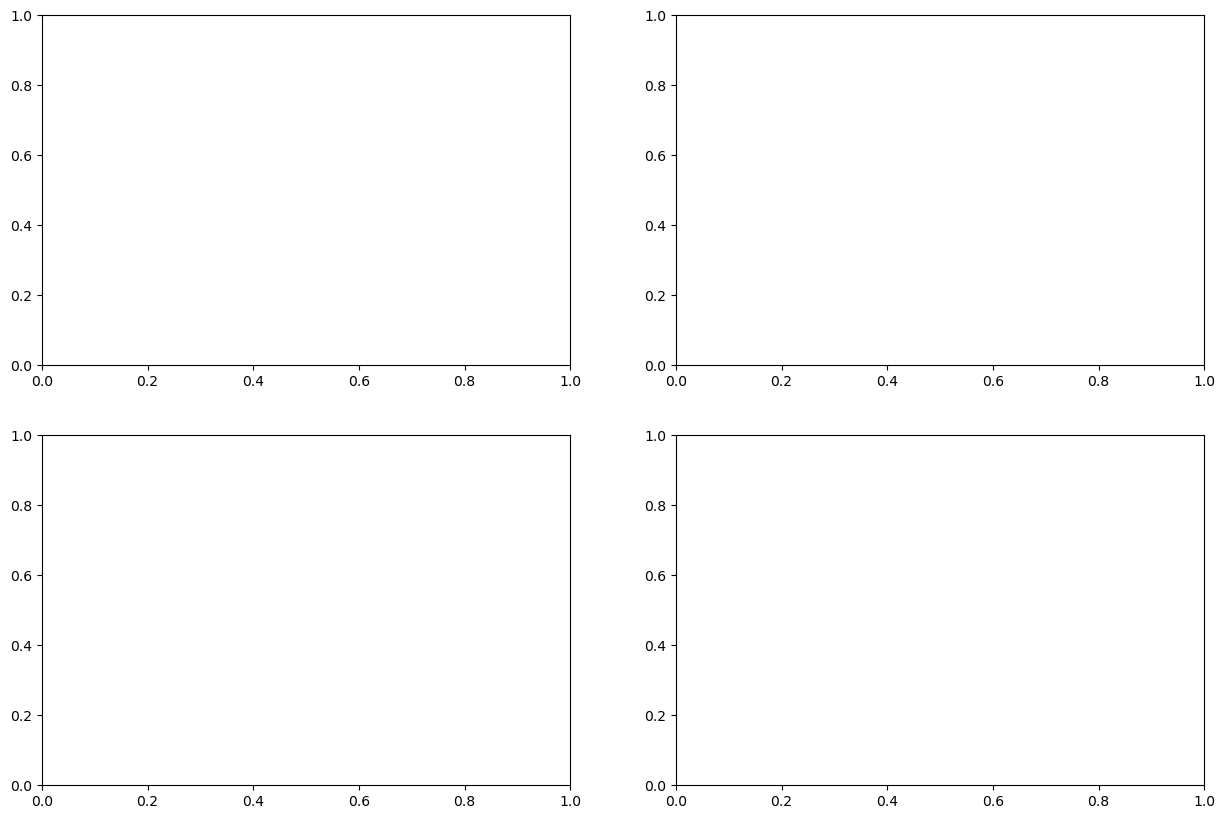

In [ ]:
# task_idx = 0
# neuron_n = 4
# batch_n = 0

# fig, axs = plt.subplots(2,2, figsize=(15,10))

# # trial_to_plot = all_ctx_exp_yhats[task_idx][neuron_n]
# # trial_to_plot = np.asarray(trial_to_plot)[:,batch_n,:]
# hm1 = sns.heatmap(np.asarray(all_task_lesioned_hids[0]), ax=axs[0][0]);
# hm2 = sns.heatmap(np.asarray(all_task_lesioned_hids[1]), ax=axs[0][1]);
# hm3 = sns.heatmap(np.asarray(all_task_lesioned_hids[2]), ax=axs[1][0]);
# hm4 = sns.heatmap(np.asarray(all_task_lesioned_hids[3]), ax=axs[1][1]);

# fig.suptitle('network hidden activations for each single neuron lesion\n' \
#              'ctx hiddens with ctx lesions')
#     # 'difference in network performance on each task after lesioning each respective neuron, \n'
#     #     'averaged across ' + str(n_reps*batch_size) + ' runs per neuron (values in abs % points) \n'
#     #     'training task structure: '+tasknames+ # ' | averaged across '+str(top_n)+' runs\n' \
#     #     '\nalpha:'+a_str[1:]+' | wd:'+wd_str[2:]+' | lr_ctx:'+ctx_lr_str[3:]+' | lr_hpc:'+hpc_lr_str[3:]+
#     #     ' | lr_c2h:'+c2h_lr_str[3:]+' | lr_h2c:'+h2c_lr_str[3:]+
#     #     '', fontsize=10)

# axs[0][0].set_title(task_list_unique[0])
# axs[0][1].set_title(task_list_unique[1])
# axs[1][0].set_title(task_list_unique[2])
# axs[1][1].set_title(task_list_unique[3])

# axs[0][0].set_xlabel('neuron activations');
# axs[0][0].set_ylabel('neuron lesioned');


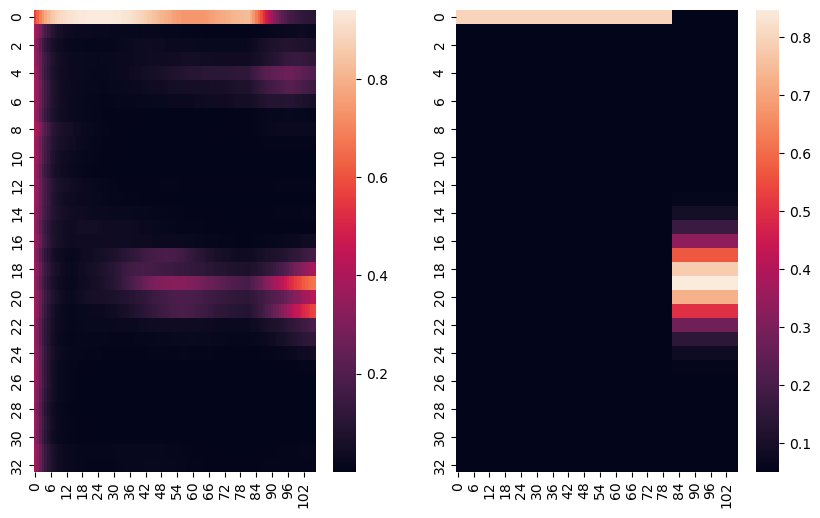

In [ ]:
# task_idx = 0
# neuron_n = 58
# batch_n = 0

# fig, axs = plt.subplots(1,2, figsize=(10,6))

# trial_to_plot = all_ctx_exp_yhats[task_idx][neuron_n]
# trial_to_plot = np.asarray(trial_to_plot)[:,batch_n,:]
# hm1 = sns.heatmap(np.asarray(trial_to_plot).T, ax=axs[0]);

# gt_plot = all_ctx_exp_trials[task_idx][neuron_n].y
# gt_plot = np.asarray(gt_plot)[:,batch_n,:]
# hm1 = sns.heatmap(np.asarray(gt_plot).T, ax=axs[1]);


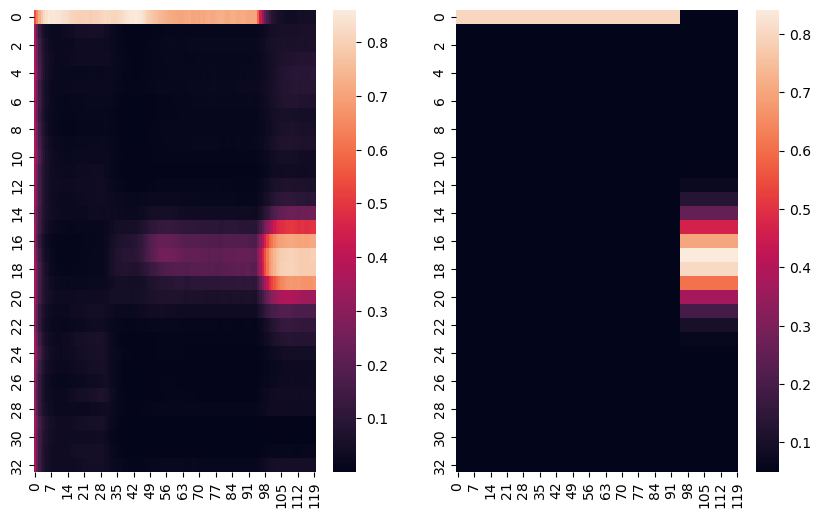

In [ ]:
# task_idx = 0
# neuron_n = 23
# batch_n = 0

# fig, axs = plt.subplots(1,2, figsize=(10,6))

# trial_to_plot = all_ctx_exp_yhats[task_idx][neuron_n]
# trial_to_plot = np.asarray(trial_to_plot)[:,batch_n,:]
# hm1 = sns.heatmap(np.asarray(trial_to_plot).T, ax=axs[0]);

# gt_plot = all_ctx_exp_trials[task_idx][neuron_n].y
# gt_plot = np.asarray(gt_plot)[:,batch_n,:]
# hm1 = sns.heatmap(np.asarray(gt_plot).T, ax=axs[1]);

#### plotting

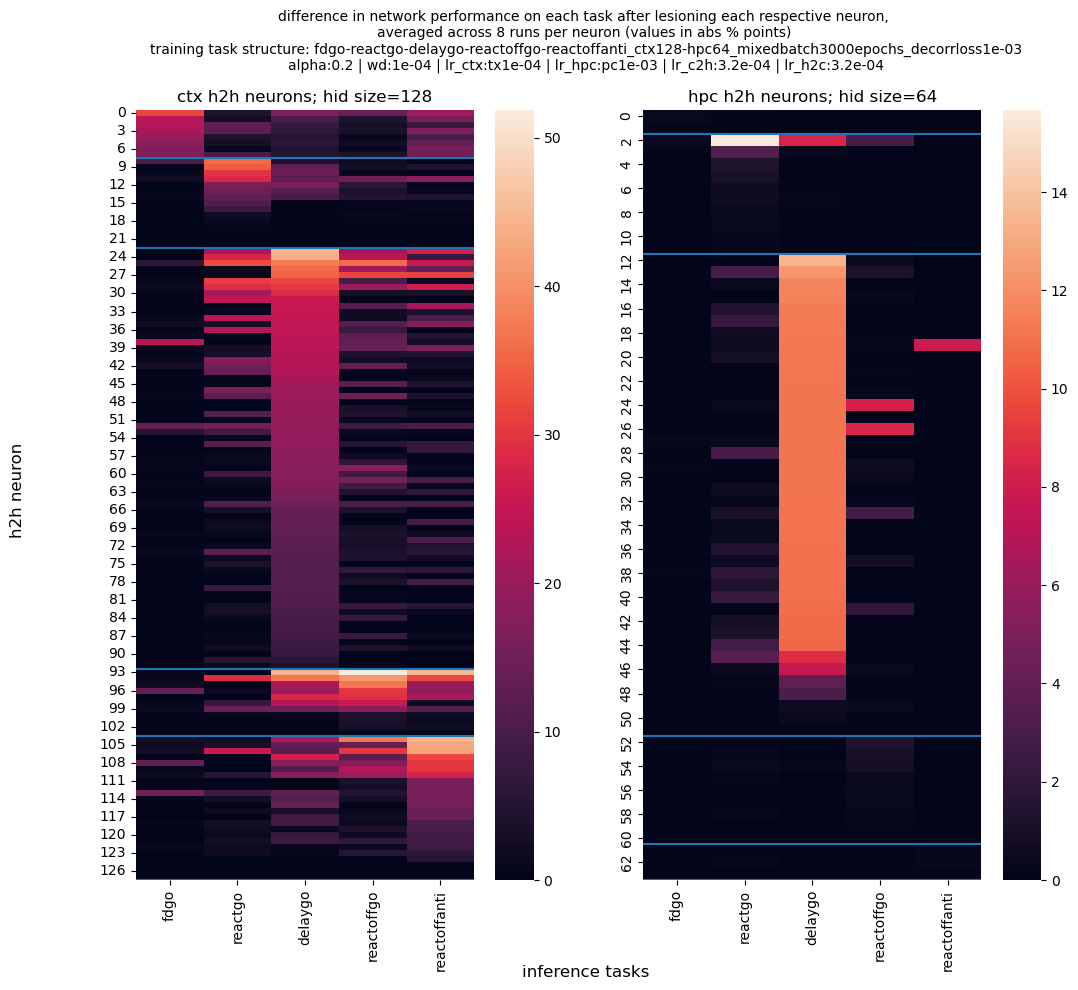

In [87]:
plot_sorted=True

ctx_lesion_hmap_dat_sorted, ctx_transition_idxs = sort_lesion_heatmap(ctx_lesion_diffs, func='zscore')
hpc_lesion_hmap_dat_sorted, hpc_transition_idxs = sort_lesion_heatmap(hpc_lesion_diffs, func='zscore') # 0.9, 3.5

if plot_sorted: ctx_hmap_dat=ctx_lesion_hmap_dat_sorted; hpc_hmap_dat=hpc_lesion_hmap_dat_sorted; 
else: ctx_hmap_dat=np.asarray(ctx_lesion_diffs).T; hpc_hmap_dat=np.asarray(hpc_lesion_diffs).T

fig, axs = plt.subplots(1,2, figsize=(12,10))
# f,(ax1,ax2,ax3,ax4) = plt.subplots(2,2)

xticklabels = task_list_unique
g1 = sns.heatmap(ctx_hmap_dat, ax=axs[0], xticklabels=xticklabels);
g2 = sns.heatmap(hpc_hmap_dat, ax=axs[1], xticklabels=xticklabels);

if plot_sorted: 
    axs[0].hlines(ctx_transition_idxs, *axs[0].get_xlim()); 
    axs[1].hlines(hpc_transition_idxs, *axs[1].get_xlim())

# fig.suptitle('evolution of weights over epochs\n' \
# 			 'x axis = '+str(n_weight_epochs)+' total ('+str(total_n_epochs)+ \
# 			 ' train epochs; weights saved every '+str(weight_save_int)+' epochs)\n' \
#             'task structure: '+tasknames, fontsize=16)
fig.suptitle('difference in network performance on each task after lesioning each respective neuron, \n'
        'averaged across ' + str(n_reps*batch_size) + ' runs per neuron (values in abs % points) \n'
        'training task structure: '+tasknames+ # ' | averaged across '+str(top_n)+' runs\n' \
        '\nalpha:'+a_str[1:]+' | wd:'+wd_str[2:]+' | lr_ctx:'+ctx_lr_str[3:]+' | lr_hpc:'+hpc_lr_str[3:]+
        ' | lr_c2h:'+c2h_lr_str[3:]+' | lr_h2c:'+h2c_lr_str[3:]+
        '', fontsize=10)

# fig.suptitle('difference in network performance on each task after lesioning each respective neuron')
axs[0].set_title('ctx h2h neurons; hid size='+str(ctx_size)) # +'x'+str(hpc_size)+')')
axs[1].set_title('hpc h2h neurons; hid size='+str(hpc_size)) # +'x'+str(hpc_size)+')')

# axs[0,0].axvline(x =vline_loc, ls='--', color = 'b' , label = 'axvline - full height')
# axs[0,1].axvline(x =vline_loc, ls='--', color = 'b' , label = 'axvline - full height')
# axs[1,0].axvline(x =vline_loc, ls='--', color = 'b' , label = 'axvline - full height')
# axs[1,1].axvline(x =vline_loc, ls='--', color = 'b' , label = 'axvline - full height')


# axs[0].set_xlabel('')
# axs[0].set_ylabel('')
fig.supxlabel('inference tasks');
fig.supylabel('h2h neuron');


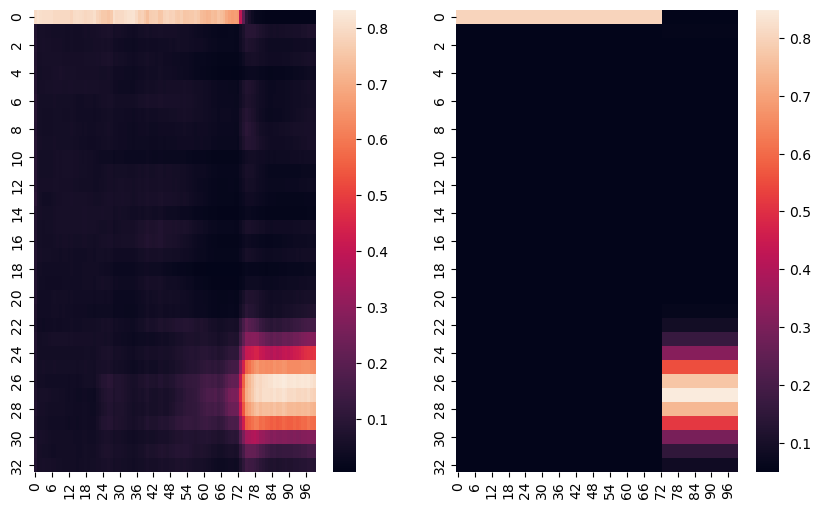

In [54]:
task_idx = 0
neuron_n = 20
batch_n = 0

fig, axs = plt.subplots(1,2, figsize=(10,6))

trial_to_plot = all_ctx_exp_yhats[task_idx][neuron_n]
trial_to_plot = np.asarray(trial_to_plot)[:,batch_n,:]
hm1 = sns.heatmap(np.asarray(trial_to_plot).T, ax=axs[0]);

gt_plot = all_ctx_exp_trials[task_idx][neuron_n].y
gt_plot = np.asarray(gt_plot)[:,batch_n,:]
hm1 = sns.heatmap(np.asarray(gt_plot).T, ax=axs[1]);


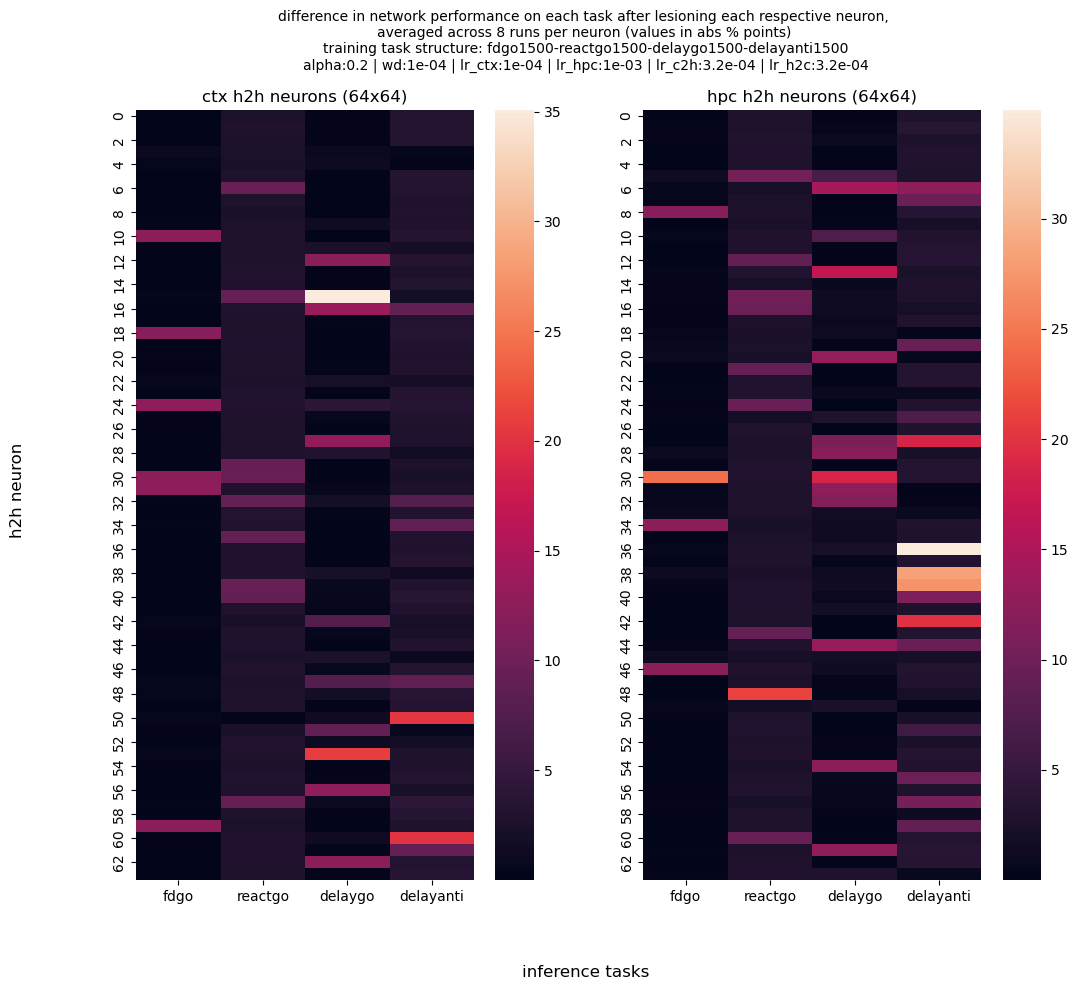

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(12,10))
# f,(ax1,ax2,ax3,ax4) = plt.subplots(2,2)

xticklabels = task_list_unique
g1 = sns.heatmap(np.asarray(ctx_lesion_diffs).T, ax=axs[0], xticklabels=xticklabels);
g2 = sns.heatmap(np.asarray(hpc_lesion_diffs).T, ax=axs[1], xticklabels=xticklabels);

# fig.suptitle('evolution of weights over epochs\n' \
# 			 'x axis = '+str(n_weight_epochs)+' total ('+str(total_n_epochs)+ \
# 			 ' train epochs; weights saved every '+str(weight_save_int)+' epochs)\n' \
#             'task structure: '+tasknames, fontsize=16)
fig.suptitle('difference in network performance on each task after lesioning each respective neuron, \n'
        'averaged across ' + str(n_reps*batch_size) + ' runs per neuron (values in abs % points) \n'
        'training task structure: '+tasknames+ # ' | averaged across '+str(top_n)+' runs\n' \
        '\nalpha:'+a_str[1:]+' | wd:'+wd_str[2:]+' | lr_ctx:'+ctx_lr_str[3:]+' | lr_hpc:'+hpc_lr_str[3:]+
        ' | lr_c2h:'+c2h_lr_str[3:]+' | lr_h2c:'+h2c_lr_str[3:]+
        '', fontsize=10)

# fig.suptitle('difference in network performance on each task after lesioning each respective neuron')
axs[0].set_title('ctx h2h neurons ('+str(ctx_size)+'x'+str(hpc_size)+')')
axs[1].set_title('hpc h2h neurons ('+str(ctx_size)+'x'+str(hpc_size)+')')

# axs[0,0].axvline(x =vline_loc, ls='--', color = 'b' , label = 'axvline - full height')
# axs[0,1].axvline(x =vline_loc, ls='--', color = 'b' , label = 'axvline - full height')
# axs[1,0].axvline(x =vline_loc, ls='--', color = 'b' , label = 'axvline - full height')
# axs[1,1].axvline(x =vline_loc, ls='--', color = 'b' , label = 'axvline - full height')


# axs[0].set_xlabel('')
# axs[0].set_ylabel('')
fig.supxlabel('inference tasks');
fig.supylabel('h2h neuron');


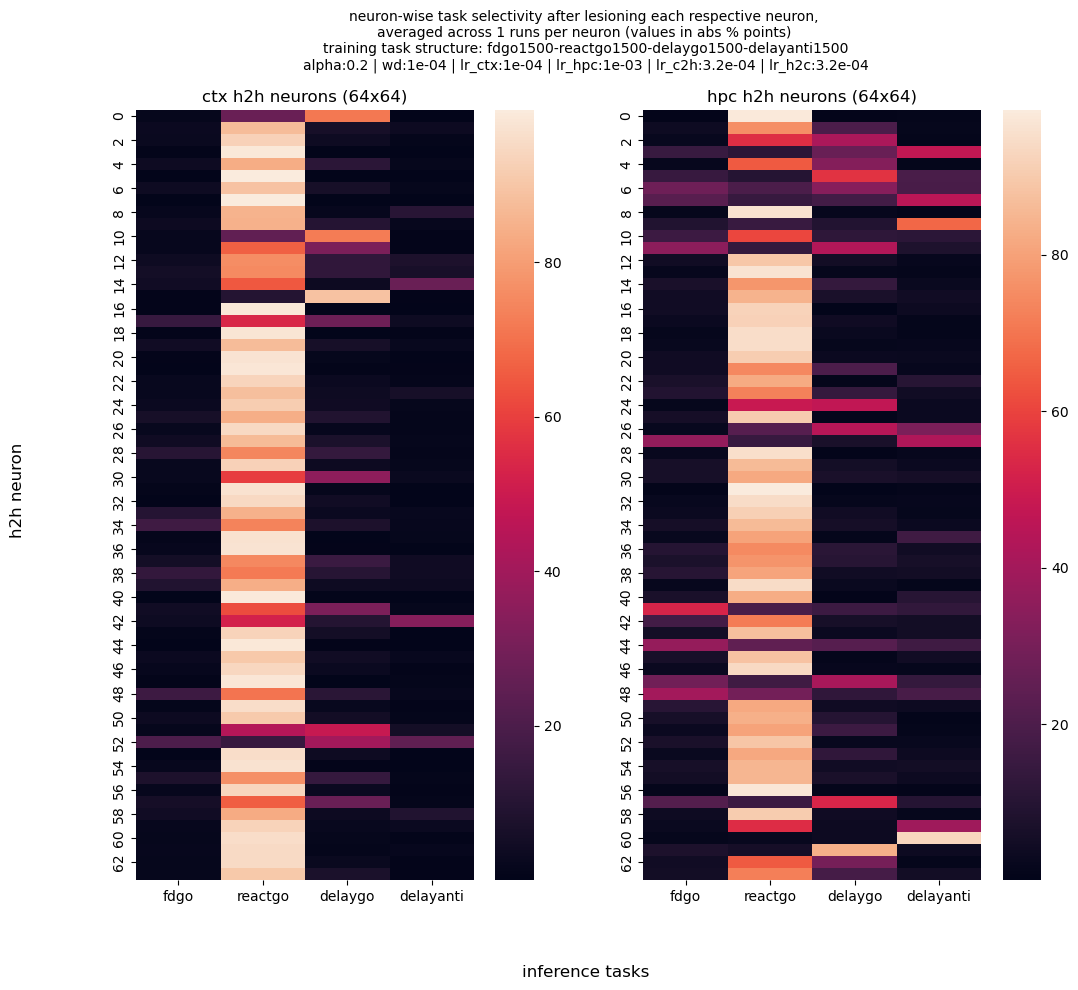

In [ ]:
#### INVERSE, SELCTIVITY


fig, axs = plt.subplots(1,2, figsize=(12,10))
# f,(ax1,ax2,ax3,ax4) = plt.subplots(2,2)

xticklabels = task_list_unique
ctx_lesion_diffs_inv = 1.0 / (np.asarray(ctx_lesion_diffs).T + 1e-8)
ctx_lesion_diffs_inv = ctx_lesion_diffs_inv / ctx_lesion_diffs_inv.sum(axis=1)[:, np.newaxis] * 100
hpc_lesion_diffs_inv = 1.0 / (np.asarray(hpc_lesion_diffs).T + 1e-8)
hpc_lesion_diffs_inv = hpc_lesion_diffs_inv / hpc_lesion_diffs_inv.sum(axis=1)[:, np.newaxis] * 100

g1 = sns.heatmap(np.asarray(ctx_lesion_diffs_inv), ax=axs[0], xticklabels=xticklabels);
g2 = sns.heatmap(np.asarray(hpc_lesion_diffs_inv), ax=axs[1], xticklabels=xticklabels);

# fig.suptitle('evolution of weights over epochs\n' \
# 			 'x axis = '+str(n_weight_epochs)+' total ('+str(total_n_epochs)+ \
# 			 ' train epochs; weights saved every '+str(weight_save_int)+' epochs)\n' \
#             'task structure: '+tasknames, fontsize=16)
fig.suptitle('neuron-wise task selectivity after lesioning each respective neuron, \n'
        'averaged across ' + str(n_reps*batch_size) + ' runs per neuron (values in abs % points) \n'
        'training task structure: '+tasknames+ # ' | averaged across '+str(top_n)+' runs\n' \
        '\nalpha:'+a_str[1:]+' | wd:'+wd_str[2:]+' | lr_ctx:'+ctx_lr_str[3:]+' | lr_hpc:'+hpc_lr_str[3:]+
        ' | lr_c2h:'+c2h_lr_str[3:]+' | lr_h2c:'+h2c_lr_str[3:]+
        '', fontsize=10)

# fig.suptitle('difference in network performance on each task after lesioning each respective neuron')
axs[0].set_title('ctx h2h neurons ('+str(ctx_size)+'x'+str(hpc_size)+')')
axs[1].set_title('hpc h2h neurons ('+str(ctx_size)+'x'+str(hpc_size)+')')

# axs[0,0].axvline(x =vline_loc, ls='--', color = 'b' , label = 'axvline - full height')
# axs[0,1].axvline(x =vline_loc, ls='--', color = 'b' , label = 'axvline - full height')
# axs[1,0].axvline(x =vline_loc, ls='--', color = 'b' , label = 'axvline - full height')
# axs[1,1].axvline(x =vline_loc, ls='--', color = 'b' , label = 'axvline - full height')


# axs[0].set_xlabel('')
# axs[0].set_ylabel('')
fig.supxlabel('inference tasks');
fig.supylabel('h2h neuron');


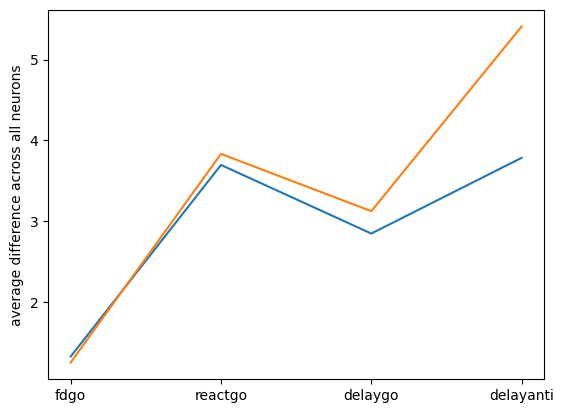

In [ ]:
plt.plot(ctx_lesion_avg_diff);
plt.plot(hpc_lesion_avg_diff);

plt.ylabel('average difference across all neurons')
plt.xticks(np.arange(len(task_list_unique)), task_list_unique);

Text(0, 0.5, 'change in performance for each neuron lesion')

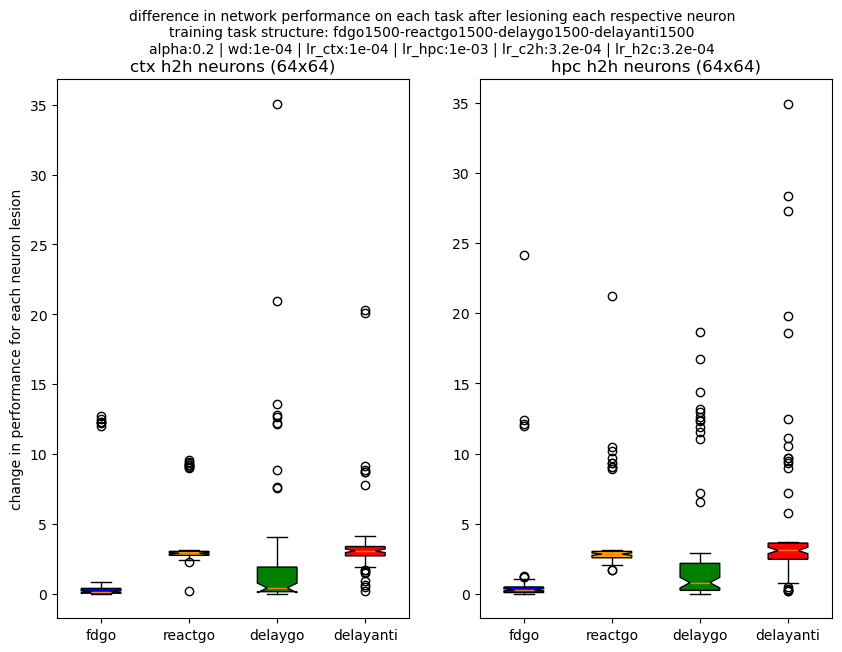

In [ ]:
# colors = ['#0000FF', '#00FF00', 
#           '#FFFF00', '#FF00FF']
colors = ['blue', 'orange', 'green', 'red']

# fig = plt.figure(figsize =(10, 7))
# ax = fig.add_subplot(111)
# axs[0].xticks(np.arange(len(task_list_unique))+1, task_list_unique);

fig, axs = plt.subplots(1,2, figsize=(10,7))

bp1 = axs[0].boxplot(np.asarray(ctx_lesion_diffs).T, patch_artist = True, notch ='True')
bp2 = axs[1].boxplot(np.asarray(hpc_lesion_diffs).T, patch_artist = True, notch ='True')

for patch, color in zip(bp1['boxes'], colors): patch.set_facecolor(color)
for patch, color in zip(bp2['boxes'], colors): patch.set_facecolor(color)

axs[0].set_xticks(np.arange(len(task_list_unique))+1)
axs[0].set_xticklabels(task_list_unique)
axs[1].set_xticks(np.arange(len(task_list_unique))+1)
axs[1].set_xticklabels(task_list_unique)

axs[0].set_title('ctx h2h neurons ('+str(ctx_size)+'x'+str(hpc_size)+')')
axs[1].set_title('hpc h2h neurons ('+str(ctx_size)+'x'+str(hpc_size)+')')

fig.suptitle('difference in network performance on each task after lesioning each respective neuron\n'
        'training task structure: '+tasknames+ # ' | averaged across '+str(top_n)+' runs\n' \
        '\nalpha:'+a_str[1:]+' | wd:'+wd_str[2:]+' | lr_ctx:'+ctx_lr_str[3:]+' | lr_hpc:'+hpc_lr_str[3:]+
        ' | lr_c2h:'+c2h_lr_str[3:]+' | lr_h2c:'+h2c_lr_str[3:]+
        '', fontsize=10)
axs[0].set_ylabel('change in performance for each neuron lesion')

### multi neuron lesions (unused)

In [ ]:
task_base_perfs = []; task_base_losses = []


all_ctx_exp_perfs_multi = []; all_ctx_exp_losses_multi = []
all_hpc_exp_perfs_multi = []; all_hpc_exp_losses_multi = []

n_lesions_list = [2,3,4,5,6,7,8]
n_lesion_runs = len(n_lesions_list)
n_reps = 16

hp['batch_size'] = 1
batch_size= hp['batch_size']
hp['mode'] = 'inference'
hp['tdim'] = 100
hp['y_loc'] = np.random.rand(batch_size)*2*np.pi
hp['probe']= 'fixed'

lesion_layer = 'h2h'
lesion_type = 'mask'

gened_trials = []
for i,task in (enumerate(task_list_unique)):
    trials = [generate_trials(task, hp, 'random', batch_size=hp['batch_size']) for _ in range(n_reps)]
    gened_trials.append(trials)


print('lesion list: ', n_lesions_list, ' | reps per: ', str(n_reps))
for _, n_lesions in tqdm(enumerate(n_lesions_list)):
    print('n neurons to lesion: ', n_lesions)
    all_ctx_exp_perfs = []; all_ctx_exp_losses = []
    all_hpc_exp_perfs = []; all_hpc_exp_losses = []

    for i,task in (enumerate(task_list_unique)):
        # print('running: ', task)
        
        repped_perf = []
        for n in range(1):
            (base_perf, base_losses), base_hids, base_trial, base_y_react \
                = run_model_inference(model, task, hp, inf_trial=gened_trials[i][n])
            repped_perf.append(base_perf*100)
        task_base_perfs.append(np.mean(repped_perf)) # ; task_base_losses.append(base_losses)

        ctx_exp_perfs = []; ctx_exp_losses = []
        hpc_exp_perfs = []; hpc_exp_losses = []
        ctx_exp_trials = []; hpc_exp_trials = []
        

        # ## Loop thru each number of n neurons neuron for lesioning
        # for j in range(n_neurons):

        #     ## run inference n_reps number of times for average
        #     # lesion_idxs = sorted(random.sample(range(0, n_neurons), n_lesions))
        #     repped_perfs = []
        #     for n in range(n_reps):
        #  perf_ctx, losses, hids, trial_ctx, y_react = run_model_inference(model_ctx_exp, task, hp, lesion=([j],'ctx')) # , time_bounds)
        #  perf_hpc, losses, hids, trial_hpc, y_react = run_model_inference(model_hpc_exp, task, hp, lesion=([j],'hpc')) # , time_bounds)
        #         repped_perfs.append([perf_ctx*100,perf_hpc*100])
        #     ctx_exp_perfs.append(np.mean([r[0] for r in repped_perfs]))# ; ctx_exp_losses.append(losses)
        #     hpc_exp_perfs.append(np.mean([r[1] for r in repped_perfs]))# ; hpc_exp_losses.append(losses)
        #     ctx_exp_trials.append(trial_ctx); hpc_exp_trials.append(trial_hpc)

        # all_ctx_exp_perfs.append(ctx_exp_perfs); all_ctx_exp_losses.append(ctx_exp_losses)
        # all_hpc_exp_perfs.append(hpc_exp_perfs); all_hpc_exp_losses.append(hpc_exp_losses)
        # all_ctx_exp_trials.append(ctx_exp_trials); all_hpc_exp_trials.append(hpc_exp_trials)
    





        for n in range(n_reps):

            neuron_idxs = sorted(random.sample(range(0, n_neurons), n_lesions))
            # print(neuron_idxs, 'this rep')
            ctx_tensors_saved = []; hpc_tensors_saved = []

            (perf_ctx, losses, yhats_ctx), hids_ctx, trial_ctx, y_react \
                = run_model_inference(model_ctx_exp, task, hp, inf_trial=gened_trials[i][n], lesion=(neuron_idxs,'ctx', lesion_layer, lesion_type), return_y=True)
            (perf_hpc, losses, yhats_hpc), hids_hpc, trial_hpc, y_react \
                = run_model_inference(model_hpc_exp, task, hp, inf_trial=gened_trials[i][n], lesion=(neuron_idxs,'hpc', lesion_layer, lesion_type), return_y=True)

            ctx_exp_perfs.append(perf_ctx*100); hpc_exp_perfs.append(perf_hpc*100)
            ctx_exp_trials.append(trial_ctx); hpc_exp_trials.append(trial_hpc)
            # ctx_exp_losses.append(losses_ctx); hpc_exp_losses.append(losses_hpc)


        all_ctx_exp_perfs.append(ctx_exp_perfs); all_ctx_exp_losses.append(ctx_exp_losses)
        all_hpc_exp_perfs.append(hpc_exp_perfs); all_hpc_exp_losses.append(hpc_exp_losses)
        all_ctx_exp_trials.append(ctx_exp_trials); all_hpc_exp_trials.append(hpc_exp_trials)

    all_ctx_exp_perfs_multi.append(all_ctx_exp_perfs); all_ctx_exp_losses_multi.append(all_ctx_exp_losses)
    all_hpc_exp_perfs_multi.append(all_hpc_exp_perfs); all_hpc_exp_losses_multi.append(all_hpc_exp_losses)

print('all_ctx_exp_perfs_multi shape: ', np.asarray(all_ctx_exp_perfs_multi).shape)

lesion list:  [2, 3, 4, 5, 6, 7, 8]  | reps per:  16


0it [00:00, ?it/s]

n neurons to lesion:  2


1it [00:03,  3.66s/it]

n neurons to lesion:  3


2it [00:06,  3.22s/it]

n neurons to lesion:  4


3it [00:09,  3.08s/it]

n neurons to lesion:  5


4it [00:12,  3.09s/it]

n neurons to lesion:  6


5it [00:15,  3.02s/it]

n neurons to lesion:  7


6it [00:18,  2.99s/it]

n neurons to lesion:  8


7it [00:21,  3.05s/it]

all_ctx_exp_perfs_multi shape:  (7, 4, 16)


In [136]:
ctx_lesion_diffs_multi = [get_lesion_perf_stats(task_base_perfs, perfs, task_list_unique) for perfs in all_ctx_exp_perfs_multi]
hpc_lesion_diffs_multi = [get_lesion_perf_stats(task_base_perfs, perfs, task_list_unique) for perfs in all_hpc_exp_perfs_multi]
print('ctx_lesion_diffs_multi shape: ', np.asarray(ctx_lesion_diffs_multi).shape)

ctx_lesion_diffs_multi shape:  (7, 4, 16)


In [ ]:
### ADD THE AVG VALUE TO THE BOTTOM
add_avg = False
ctx_lesion_avg_diff_multi = []
hpc_lesion_avg_diff_multi = []

for z in range(n_lesion_runs):
    ctx_lesion_avg_diff = []; hpc_lesion_avg_diff = []
    ctx_lesion_diffs = ctx_lesion_diffs_multi[z]
    hpc_lesion_diffs = hpc_lesion_diffs_multi[z]

    lesion_diff_shape = np.asarray(ctx_lesion_diffs).shape
    for i in range(lesion_diff_shape[0]):
        avg_ctx = np.mean(ctx_lesion_diffs[i])
        avg_hpc = np.mean(hpc_lesion_diffs[i])

        ctx_lesion_avg_diff.append(avg_ctx)
        hpc_lesion_avg_diff.append(avg_hpc)
        if add_avg:
            ctx_lesion_diffs[i].append(avg_ctx)
            hpc_lesion_diffs[i].append(avg_hpc)
    
    ctx_lesion_avg_diff_multi.append(ctx_lesion_avg_diff)
    hpc_lesion_avg_diff_multi.append(hpc_lesion_avg_diff)
    
print('ctx_lesion_avg_diff_multi shape: ', np.asarray(ctx_lesion_avg_diff_multi).shape)

ctx_lesion_avg_diff_multi shape:  (7, 4)


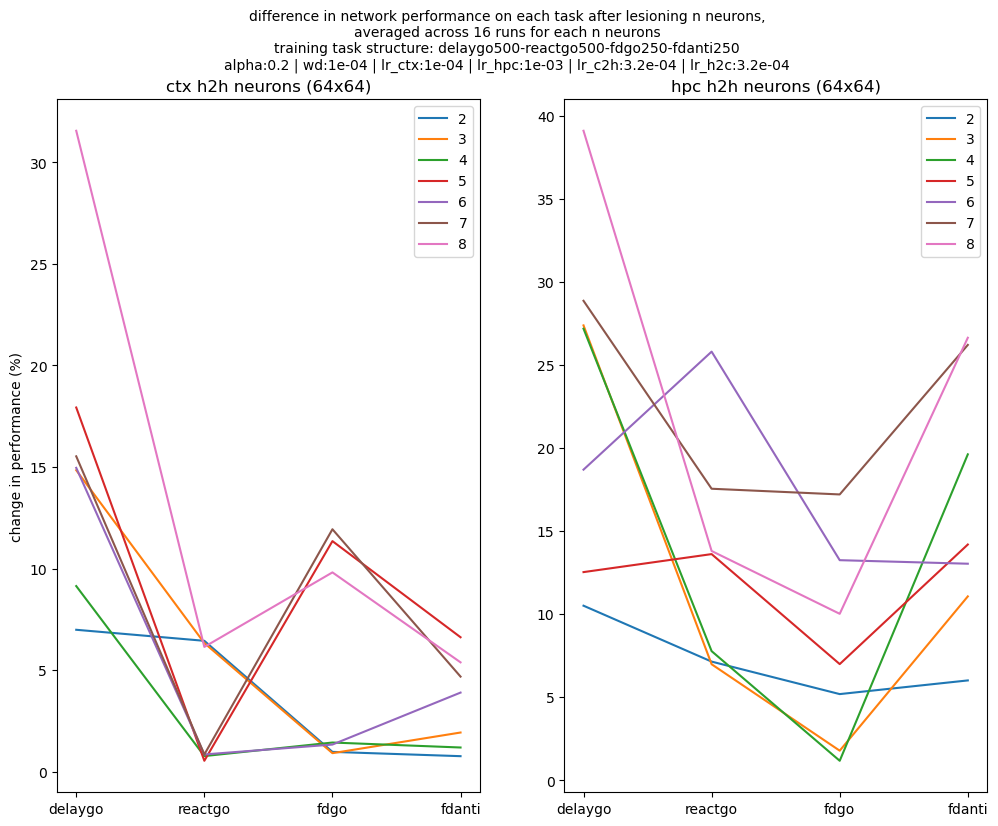

In [ ]:

fig, axs = plt.subplots(1,2, figsize=(12,9))


for i,ctx_lesion_avg_diff in enumerate(ctx_lesion_avg_diff_multi):
    lbl = str(n_lesions_list[i])
    axs[0].plot(ctx_lesion_avg_diff, label=lbl);
    axs[1].plot(hpc_lesion_avg_diff_multi[i], label=lbl);


axs[0].set_xticks(np.arange(len(task_list_unique)))
axs[0].set_xticklabels(task_list_unique)
axs[1].set_xticks(np.arange(len(task_list_unique)))
axs[1].set_xticklabels(task_list_unique)

# plt.xticks(np.arange(len(task_list_unique)), task_list_unique);
axs[0].set_title('ctx h2h neurons ('+str(ctx_size)+'x'+str(hpc_size)+')')
axs[1].set_title('hpc h2h neurons ('+str(ctx_size)+'x'+str(hpc_size)+')')
axs[0].legend(); axs[1].legend()

#  
fig.suptitle('difference in network performance on each task after lesioning n neurons,\n'
        'averaged across ' + str(n_reps) + ' runs for each n neurons\n'
        'training task structure: '+tasknames+ # ' | averaged across '+str(top_n)+' runs\n' \
        '\nalpha:'+a_str[1:]+' | wd:'+wd_str[2:]+' | lr_ctx:'+ctx_lr_str[3:]+' | lr_hpc:'+hpc_lr_str[3:]+
        ' | lr_c2h:'+c2h_lr_str[3:]+' | lr_h2c:'+h2c_lr_str[3:]+
        '', fontsize=10)
axs[0].set_ylabel('change in performance (%)');

#### plotting

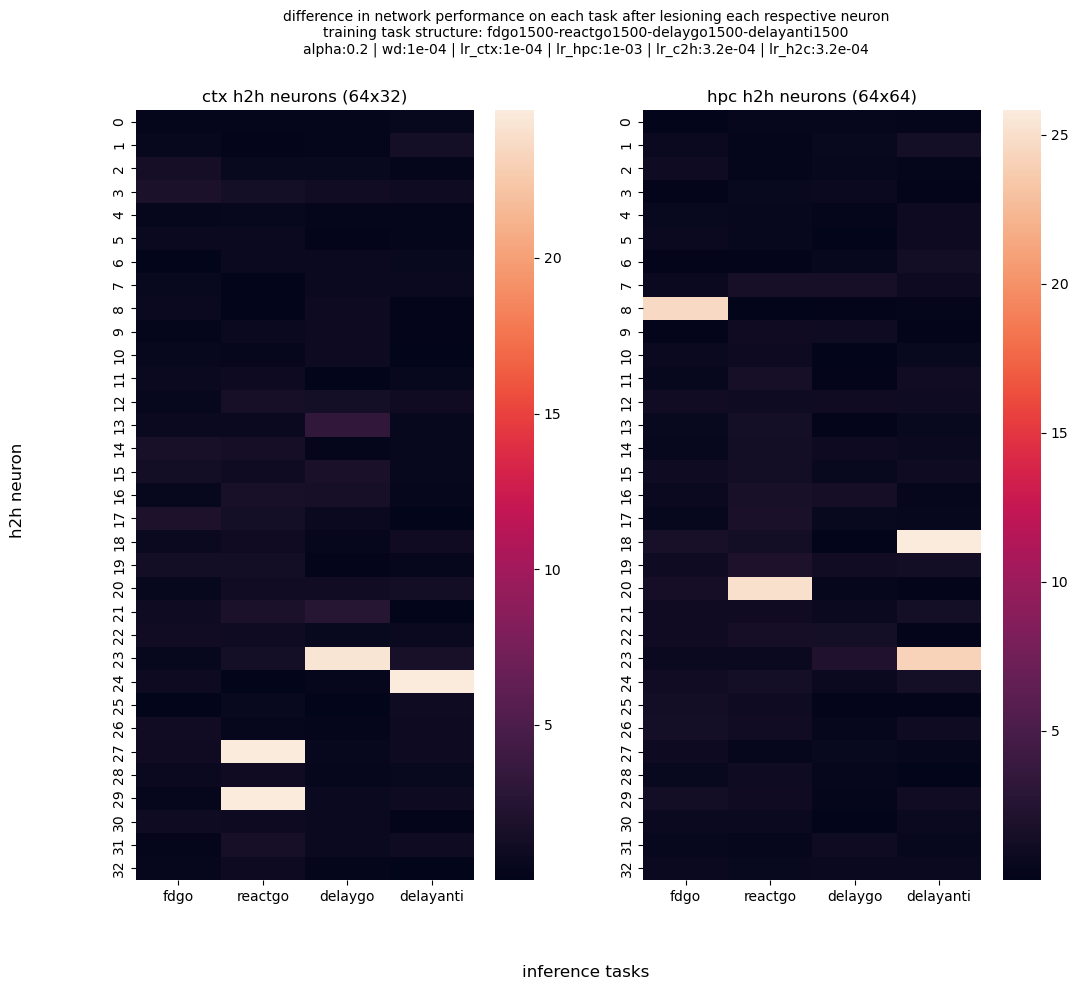

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(12,10))
# f,(ax1,ax2,ax3,ax4) = plt.subplots(2,2)

xticklabels = task_list_unique
g1 = sns.heatmap(np.asarray(ctx_lesion_diffs).T, ax=axs[0], xticklabels=xticklabels);
g2 = sns.heatmap(np.asarray(hpc_lesion_diffs).T, ax=axs[1], xticklabels=xticklabels);

# fig.suptitle('evolution of weights over epochs\n' \
# 			 'x axis = '+str(n_weight_epochs)+' total ('+str(total_n_epochs)+ \
# 			 ' train epochs; weights saved every '+str(weight_save_int)+' epochs)\n' \
#             'task structure: '+tasknames, fontsize=16)
fig.suptitle('difference in network performance on each task after lesioning each respective neuron\n'
        'training task structure: '+tasknames+ # ' | averaged across '+str(top_n)+' runs\n' \
        '\nalpha:'+a_str[1:]+' | wd:'+wd_str[2:]+' | lr_ctx:'+ctx_lr_str[3:]+' | lr_hpc:'+hpc_lr_str[3:]+
        ' | lr_c2h:'+c2h_lr_str[3:]+' | lr_h2c:'+h2c_lr_str[3:]+
        '', fontsize=10)

# fig.suptitle('difference in network performance on each task after lesioning each respective neuron')
axs[0].set_title('ctx h2h neurons ('+str(ctx_size)+'x'+str(hpc_size)+')')
axs[1].set_title('hpc h2h neurons ('+str(ctx_size)+'x'+str(hpc_size)+')')

# axs[0,0].axvline(x =vline_loc, ls='--', color = 'b' , label = 'axvline - full height')
# axs[0,1].axvline(x =vline_loc, ls='--', color = 'b' , label = 'axvline - full height')
# axs[1,0].axvline(x =vline_loc, ls='--', color = 'b' , label = 'axvline - full height')
# axs[1,1].axvline(x =vline_loc, ls='--', color = 'b' , label = 'axvline - full height')


# axs[0].set_xlabel('')
# axs[0].set_ylabel('')
fig.supxlabel('inference tasks');
fig.supylabel('h2h neuron');


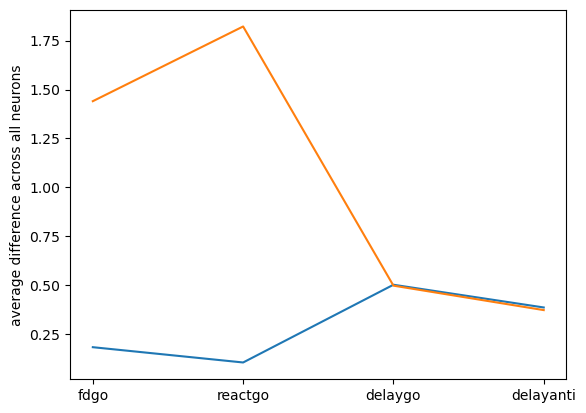

In [ ]:
plt.plot(ctx_lesion_avg_diff);
plt.plot(hpc_lesion_avg_diff);

plt.ylabel('average difference across all neurons')
plt.xticks(np.arange(len(task_list_unique)), task_list_unique);

Text(0, 0.5, 'change in performance for each neuron lesion')

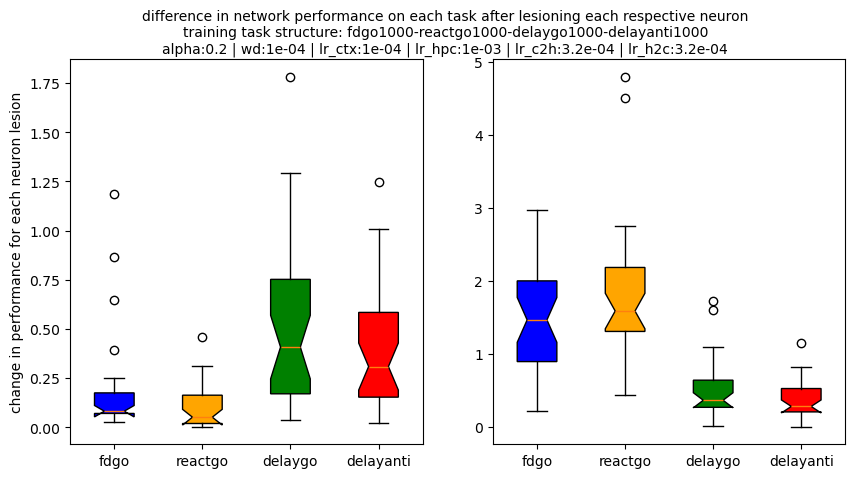

In [ ]:
# colors = ['#0000FF', '#00FF00', 
#           '#FFFF00', '#FF00FF']
colors = ['blue', 'orange', 'green', 'red']

# fig = plt.figure(figsize =(10, 7))
# ax = fig.add_subplot(111)
# axs[0].xticks(np.arange(len(task_list_unique))+1, task_list_unique);

fig, axs = plt.subplots(1,2, figsize=(10,5))

bp1 = axs[0].boxplot(np.asarray(ctx_lesion_diffs).T, patch_artist = True, notch ='True')
bp2 = axs[1].boxplot(np.asarray(hpc_lesion_diffs).T, patch_artist = True, notch ='True')

for patch, color in zip(bp1['boxes'], colors): patch.set_facecolor(color)
for patch, color in zip(bp2['boxes'], colors): patch.set_facecolor(color)

axs[0].set_xticks(np.arange(len(task_list_unique))+1)
axs[0].set_xticklabels(task_list_unique)
axs[1].set_xticks(np.arange(len(task_list_unique))+1)
axs[1].set_xticklabels(task_list_unique)

fig.suptitle('difference in network performance on each task after lesioning each respective neuron\n'
        'training task structure: '+tasknames+ # ' | averaged across '+str(top_n)+' runs\n' \
        '\nalpha:'+a_str[1:]+' | wd:'+wd_str[2:]+' | lr_ctx:'+ctx_lr_str[3:]+' | lr_hpc:'+hpc_lr_str[3:]+
        ' | lr_c2h:'+c2h_lr_str[3:]+' | lr_h2c:'+h2c_lr_str[3:]+
        '', fontsize=10)
axs[0].set_ylabel('change in performance for each neuron lesion')